# Profiling of chlorine and bleach in plants

## Import packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import lir

from matplotlib.colors import LinearSegmentedColormap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, Normalizer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scipy.stats import gaussian_kde
from scipy import stats

In [2]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 10)

In [3]:
#Design colormap
mycolors6 = ["#8F1B07","#D41262","#F0A058","#215584","#A5CD90","#2379C7"]
mycolors7 = ["#215584","#A5CD90","#44948F","#2379C7","#FFD133","#F0A058","#C22A1E"]
sns.set_palette(mycolors6)
mycmap6 = matplotlib.colors.LinearSegmentedColormap.from_list("", mycolors6)
mycmap7 = matplotlib.colors.LinearSegmentedColormap.from_list("", mycolors7)

## Summary data processing

Data were first processed with Compound Discoverer 3.3 (Thermo Scientific). Peak areas were calculated by automatic integration of the extracted ion chromatogram of the identified compounds after subtraction of a negative control baseline signal as obtained for non-exposed plants. An inclusion table was established based on the first full-scan results. A large fraction of chlorinated chemicals did not match with a compound in the Chemspider database and only a formula was given. In contrast, for most non-chlorinated chemicals a match was found with the database. Consequently, the non-chlorinated chemicals in the blank were compared to the formulas of unidentified chlorinated chemicals in the treated samples. It was hypothesized that the -OH or -H would be replaced by a chlorine atom. For instance, dopamine (C8H11NO2) was identified in the blank samples and a compound with formula C8H10ClNO2 was found in the treated samples. This sample was preliminary identified as dopamine + Cl* and the mass was added to the inclusion table.  Only chlorinated chemicals were included in the final selection. Ultimately, the markers are also visible in future research where samples might be exposed to even lower concentrations, therefore small peaks (area < 1E7, <1% of maximum peak) were excluded. In addition, the chemical should have been identified in at least 3 repetitions of either the bleach or chlorine samples. By applying those criteria, the number of compounds was reduced from 13000 to 150. Finally, only compounds were considered that were either tentatively identified by MS/MS or present as non-chlorinated compound in the blank, resulting in 95 markers.

## Import data

In [4]:
data_pivot_MSMS = pd.read_csv('df/PlantBiomarkers2_data_pivot_MSMS.csv', sep=',', encoding='latin1').pivot_table(index=["Source", "Source2", "Exposure", 'Plant', 'N'])
data_pivot_MSMS

(1S,2R,3S,5S,6S,16E,18E,20R,21S)-11-Chloro-21-hydroxy-12,20-dimethoxy-2,5,16-trimethyl-8,23-dioxo-4,24-dioxa-9,22-diazatetracyclo[19.3.1.1~10,14~.0~3,5~]hexacosa-10(26),11,13,16,18-pentaen-6-yl 2-meth\nylpropanoate  \
Source Source2     Exposure            Plant    N                                                                                                                                                                                                                           
Bleach Bleach high Concentrated bleach Euonymus 1                                              0.000                                                                                                                                                                        
                                                2                                              0.000                                                                                                                                                                        
                                                3                                              0.000                                                                                                                                                                        
                                       Grass    1                                          69888.969                                                                                                                                                                        
                                                2                                              0.000                                                                                                                                                                        
...                                                                                              ...                                                                                                                                                                        
Cl     Cl          Chlorine, short     Nettle   2                                              0.000                                                                                                                                                                        
                                                3                                              0.000                                                                                                                                                                        
                                                4                                              0.000                                                                                                                                                                        
                                                5                                              0.000                                                                                                                                                                        
                                                6                                              0.000                                                                                                                                                                        

                                                   (Z)-4-Chloro-N-(3-ethoxy-1-hydroxy-3-oxopropylidene)tryptophan  \
Source Source2     Exposure            Plant    N                                                                   
Bleach Bleach high Concentrated bleach Euonymus 1                                           0.000000                
                                                2                                           0.000000                
                                                3                                    

## Data visualization

### Histograms

Histogram of all measured concentrations:


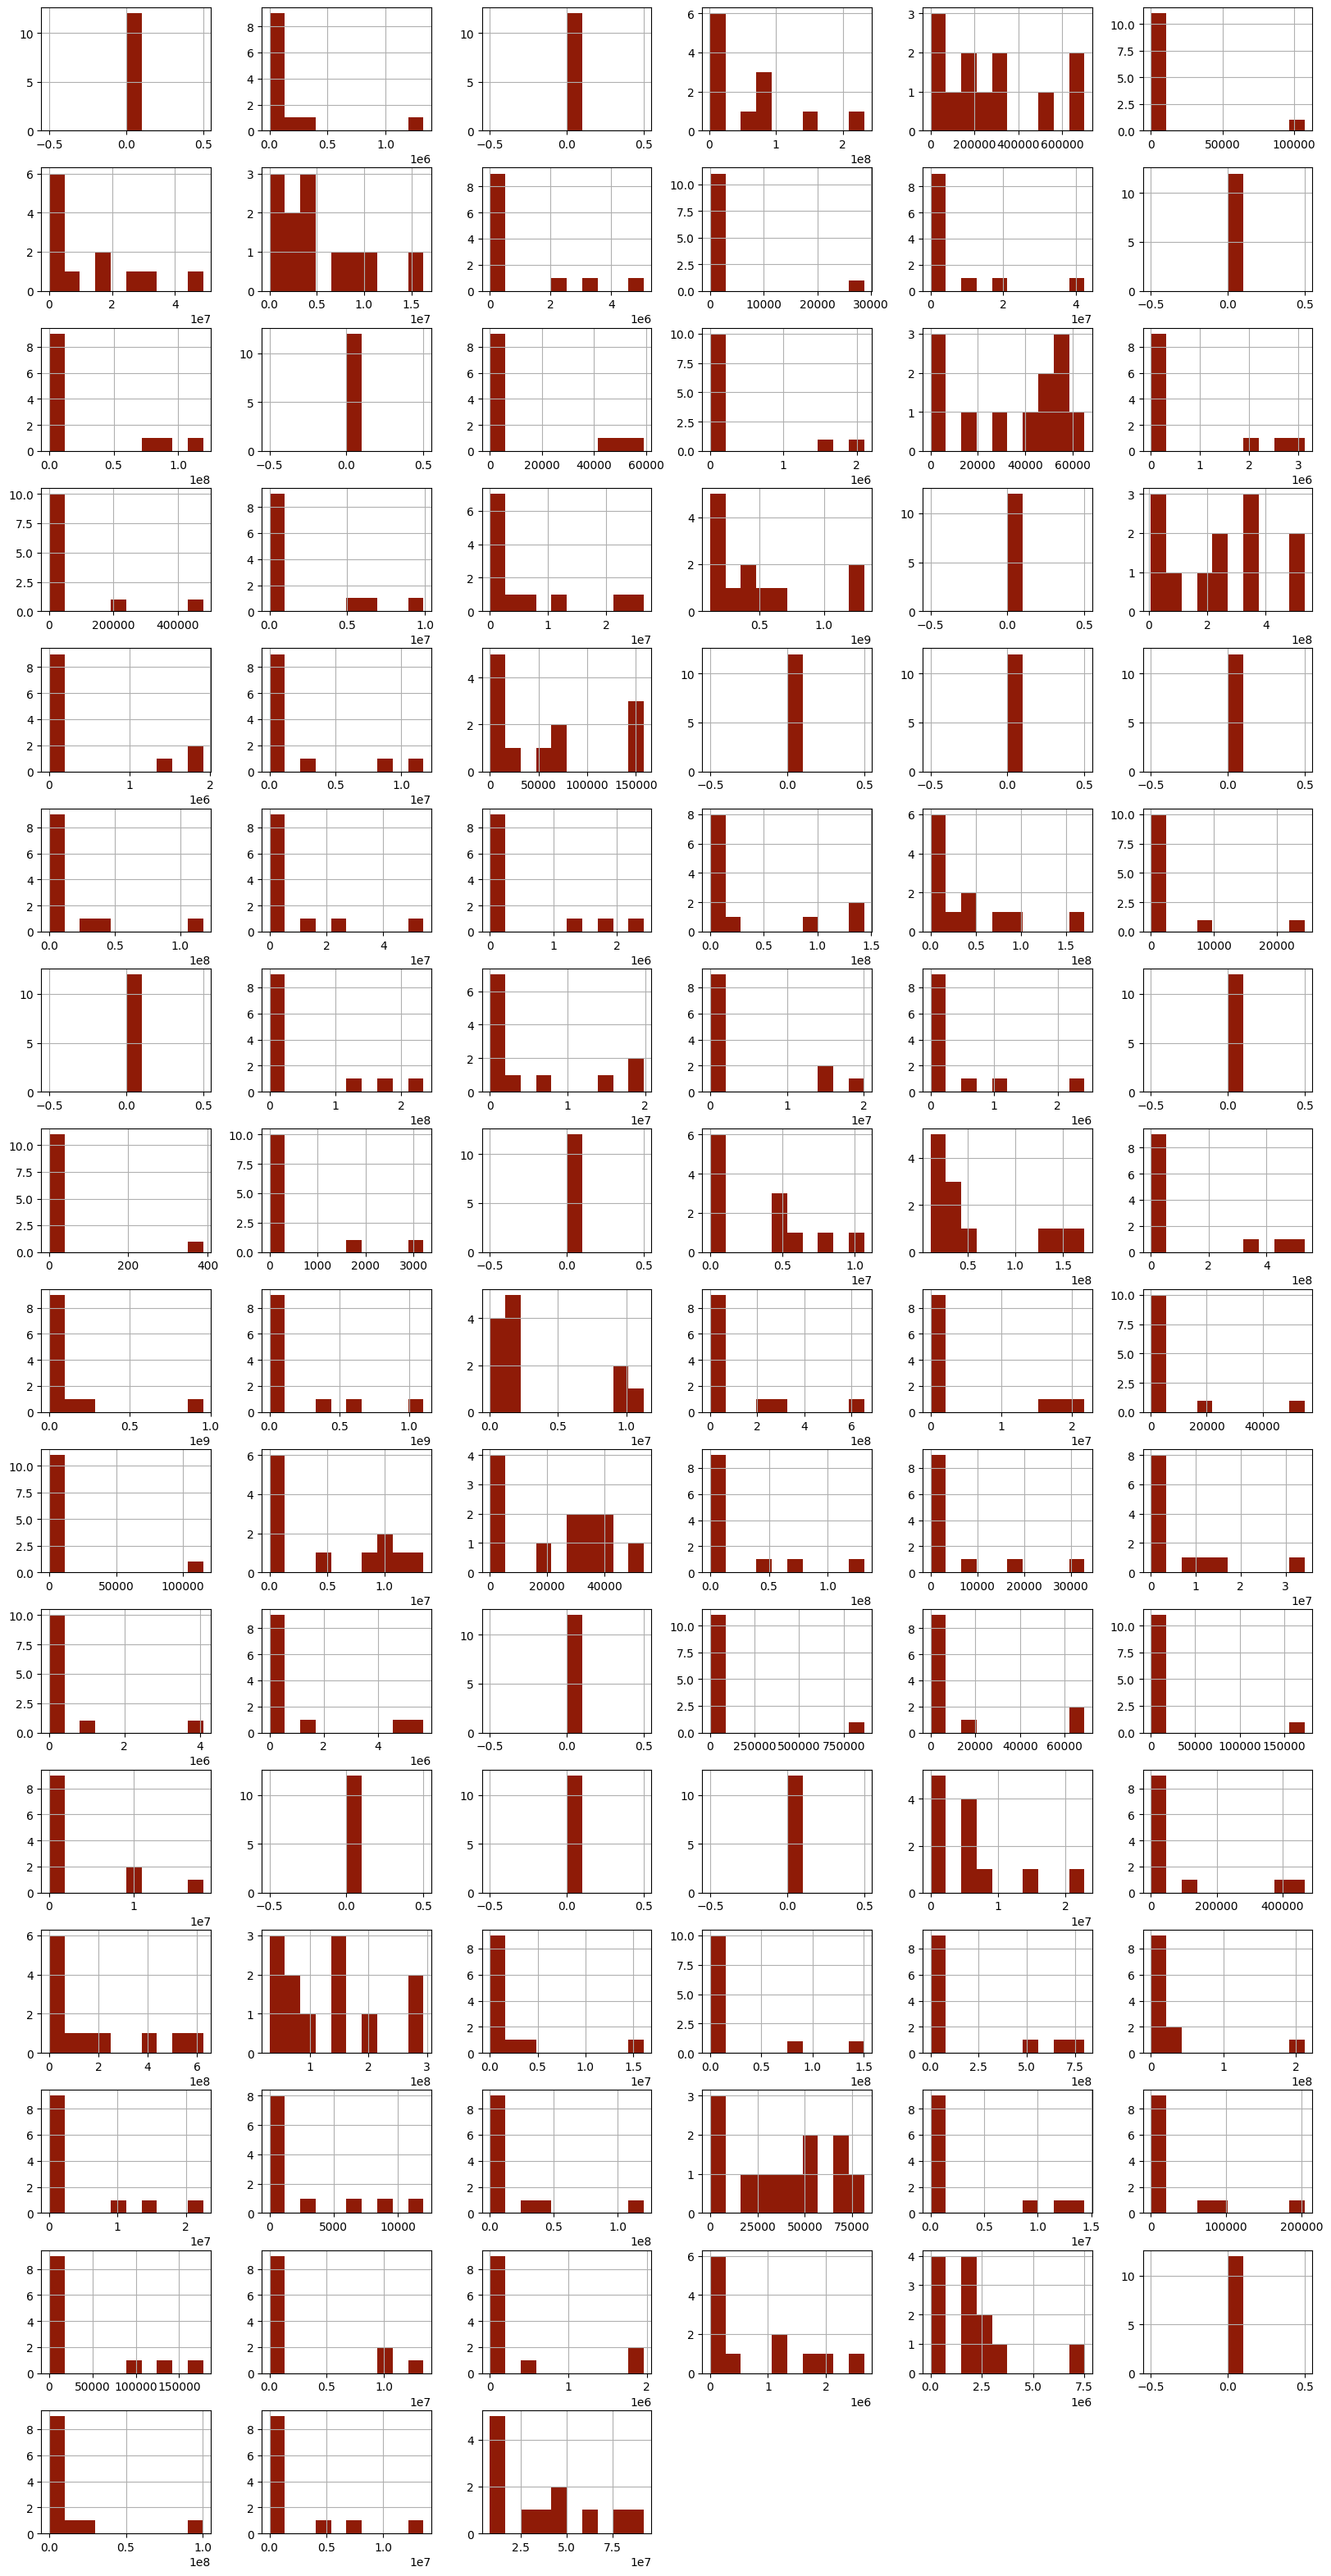

In [5]:
print("Histogram of all measured concentrations:")
axs = data_pivot_MSMS.xs(level="Exposure", key="Chlorine, high").hist(figsize=(20,40), layout=(16,6))
for ax in axs.flatten():
    ax.set_title("")

### Barchart

In [6]:
data_mean = data_pivot_MSMS.groupby(['Source']).agg('mean')
data_mean

,"(1S,2R,3S,5S,6S,16E,18E,20R,21S)-11-Chloro-21-hydroxy-12,20-dimethoxy-2,5,16-trimethyl-8,23-dioxo-4,24-dioxa-9,22-diazatetracyclo[19.3.1.1~10,14~.0~3,5~]hexacosa-10(26),11,13,16,18-pentaen-6-yl 2-meth\nylpropanoate",(Z)-4-Chloro-N-(3-ethoxy-1-hydroxy-3-oxopropylidene)tryptophan,1-(3-Chloro-2-fluorophenyl)-3-(dimethylamino)prop-2-en-1-one,1-Hydroperoxy-L-tryptophan + Cl*,"1-Methyl-1,4-dihydronicotinamide + Cl*","1-[3-(3,4-dichlorophenoxy)-2-hydroxypropyl]piperidine-4-carboxamide",13(S)-HpOTrE + Cl*,13S-hydroxyoctadecadienoic acid + 3Cl*,"2,4-DB","2,4-Diamino-6-chloropyrimidine",...,Valine + 2Cl*,bupropion,ciproximide,clominorex,cloxyquin,doxefazepam,n-butylamine + 2Cl*,p-Chloroacetophenone,seclazone,Â 12-oxo-phytodienoic acid + Cl*
Source,,,,,,,,,,,,,,,,,,,,,
Bleach,102023.830742,1.985424e+04,1.420754e+07,1.760288e+05,7.705838e+06,4.632883e+07,1.616816e+07,3.013587e+06,0.000000e+00,235383.324105,...,6.502729e+06,1.912172e+06,1.411691e+05,2.412655e+05,2.782137e+06,8.800352e+05,2.494836e+07,1.544852e+05,51816.895759,4.176779e+07
Cl,745811.805692,1.460004e+07,8.836702e+04,6.764055e+07,4.077512e+05,2.754850e+03,1.339995e+07,8.033912e+06,1.101051e+06,624251.260582,...,9.592700e+03,1.074409e+06,2.253213e+06,1.380723e+06,5.380612e+05,1.549757e+06,0.000000e+00,1.505436e+07,969989.648481,4.115531e+07


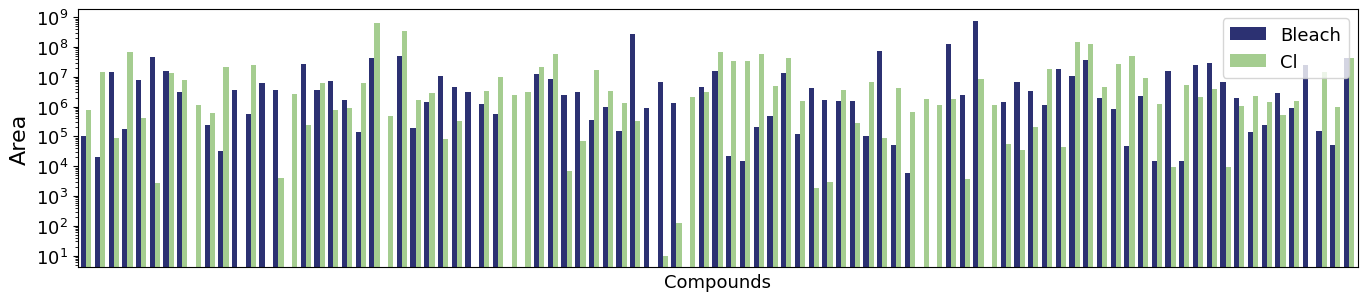

In [7]:
data_mean.T.plot.bar(figsize=(16,6), cmap="crest_r", width=0.75) #cps1_samples or cps1_objects or cps1_standards or cps1_samples_high

plt.ylabel("Area", fontsize = 16) # or "Counts ($\mathregular{s^{-1}}$
plt.xlabel("Compounds", fontsize = 13)
plt.xticks([]) #rotation=60, ha='right', fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(fontsize = 13)
plt.yscale('log')
# plt.legend(['Wire', 'Tube', 'Jerrycan', 'Tape'], loc='upper center', bbox_to_anchor=(0.5, -0.4),
#           fancybox=True, shadow=True, ncol=7, fontsize = 14)

plt.gcf().subplots_adjust(bottom=0.45, left = 0.1)

#plt.savefig('img/Bar_ChlorinePlants_all.svg') # Save image.

### Correlation

<Axes: >

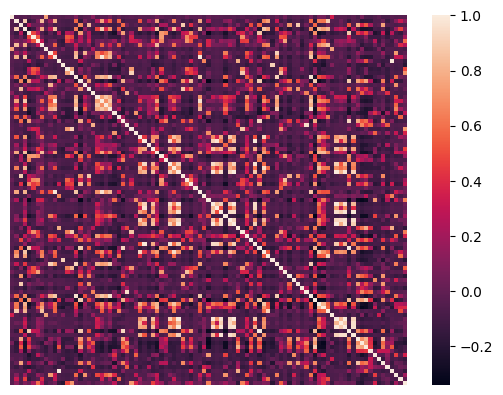

In [8]:
sns.heatmap(data_pivot_MSMS.corr(), xticklabels=False, yticklabels=False)

/tmp/ipykernel_9857/3817055492.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  corr.applymap(func),


<Axes: >

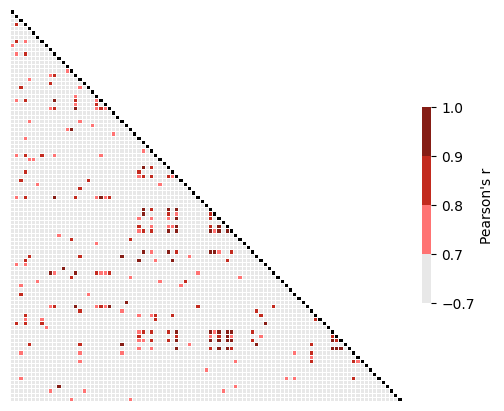

In [9]:
fig, ax = plt.subplots(figsize=(5,4), layout="constrained")

corr = data_pivot_MSMS.corr()

mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

colors = ["#E8E8E8", "#FF7373", "#C22A1E", "#851D15"]
cmap = LinearSegmentedColormap.from_list("Custom", colors, N=4)
cmap.set_over(color="black")

def func(x):
    if abs(x) < .7:
        return .6
    elif x == 1:
        return 1
    else:
        return x // .1 * .1

sns.heatmap(
    corr.applymap(func), 
    mask=mask,
    cmap=cmap,
    vmin=.6,
    vmax=.99,
    linewidths=.5, 
    fmt='.3f',
    cbar_kws={"shrink": .5, "boundaries": [-.7, .7, .8, .9, 1], "label": "Pearson's r"}, 
    square=True,
    xticklabels=False,
    yticklabels=False
)

## Chemometrics

### t-SNE

<Axes: >

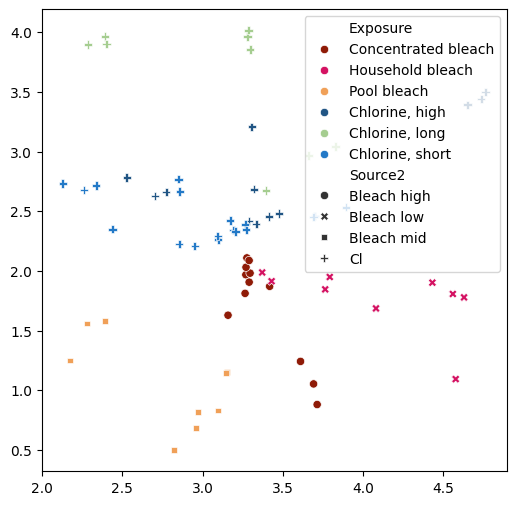

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
scaler = StandardScaler()
embedding = TSNE(init='random', perplexity=50, random_state=21).fit_transform(scaler.fit_transform(data_pivot_MSMS))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=data_pivot_MSMS.index.get_level_values('Exposure'), style=data_pivot_MSMS.index.get_level_values('Source2'), ax=ax, legend=True)

### PCA

#### Effect of preprocessing

In [11]:
pca = PCA()

class NoOpTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X
    
p = Pipeline([('scaler', NoOpTransformer()), ('pca', pca)])
p['pca']

PCA()

In [12]:
results = dict(
    no_preprocessing = Pipeline([('scaler', NoOpTransformer()), ('pca', pca)]),
    StandardScaler   = Pipeline([('scaler', StandardScaler()), ('pca', pca)]),
    RobustScaler   = Pipeline([('scaler', RobustScaler()), ('pca', pca)]),
    MinMaxScaler   = Pipeline([('scaler', MinMaxScaler()), ('pca', pca)]),
    MaxAbsScaler   = Pipeline([('scaler', MaxAbsScaler()), ('pca', pca)]),
    QuantileTransformer   = Pipeline([('scaler', QuantileTransformer(n_quantiles=6)), ('pca', pca)]),
    Normalizer   = Pipeline([('scaler', Normalizer()), ('pca', pca)]))

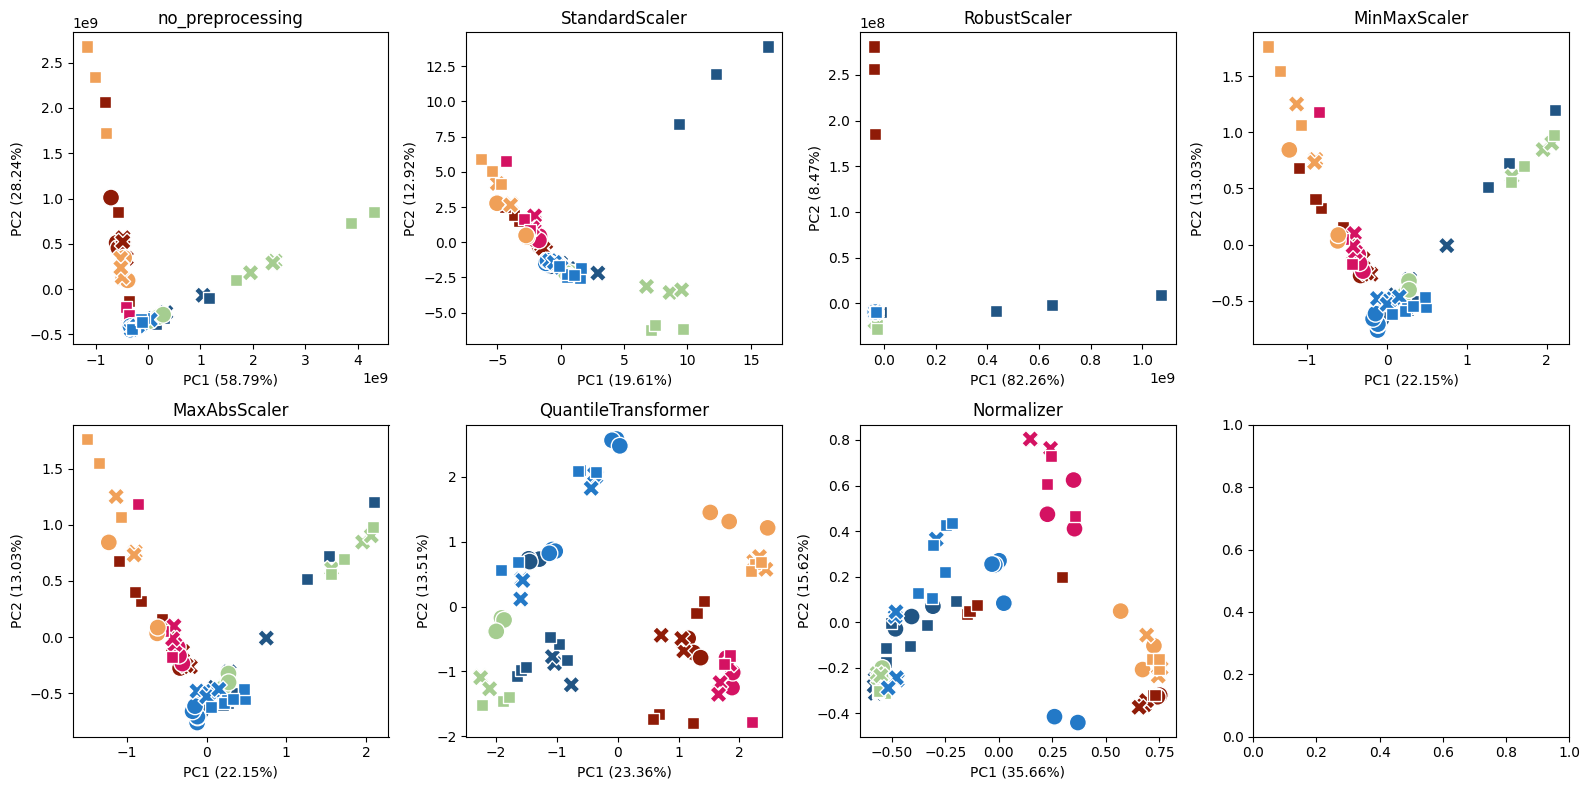

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,8), layout="tight")
for (label, result), ax in zip(results.items(), axs.flatten()):
    model = result.fit(data_pivot_MSMS)
    data = pd.DataFrame(model.transform(data_pivot_MSMS), index=data_pivot_MSMS.index).reset_index()
    sns.scatterplot(data=data, x=0, y=1, hue='Exposure', style="Plant", s=150, palette=mycolors6, legend=False, ax=ax) #palette="viridis", 
    ax.set(title=label, xlabel=f"PC1 ({model['pca'].explained_variance_ratio_[0]:.2%})", ylabel=f"PC2 ({model['pca'].explained_variance_ratio_[1]:.2%})")

#### Normalization

In [14]:
cps_norm = pd.DataFrame(QuantileTransformer(n_quantiles=6).fit_transform(data_pivot_MSMS), index=data_pivot_MSMS.index)
#cps_norm = pd.DataFrame(StandardScaler().fit_transform(data_pivot_MSMS), index=data_pivot_MSMS.index)

In [15]:
cps_norm.shape[0]

69

Histogram of all measured concentrations:


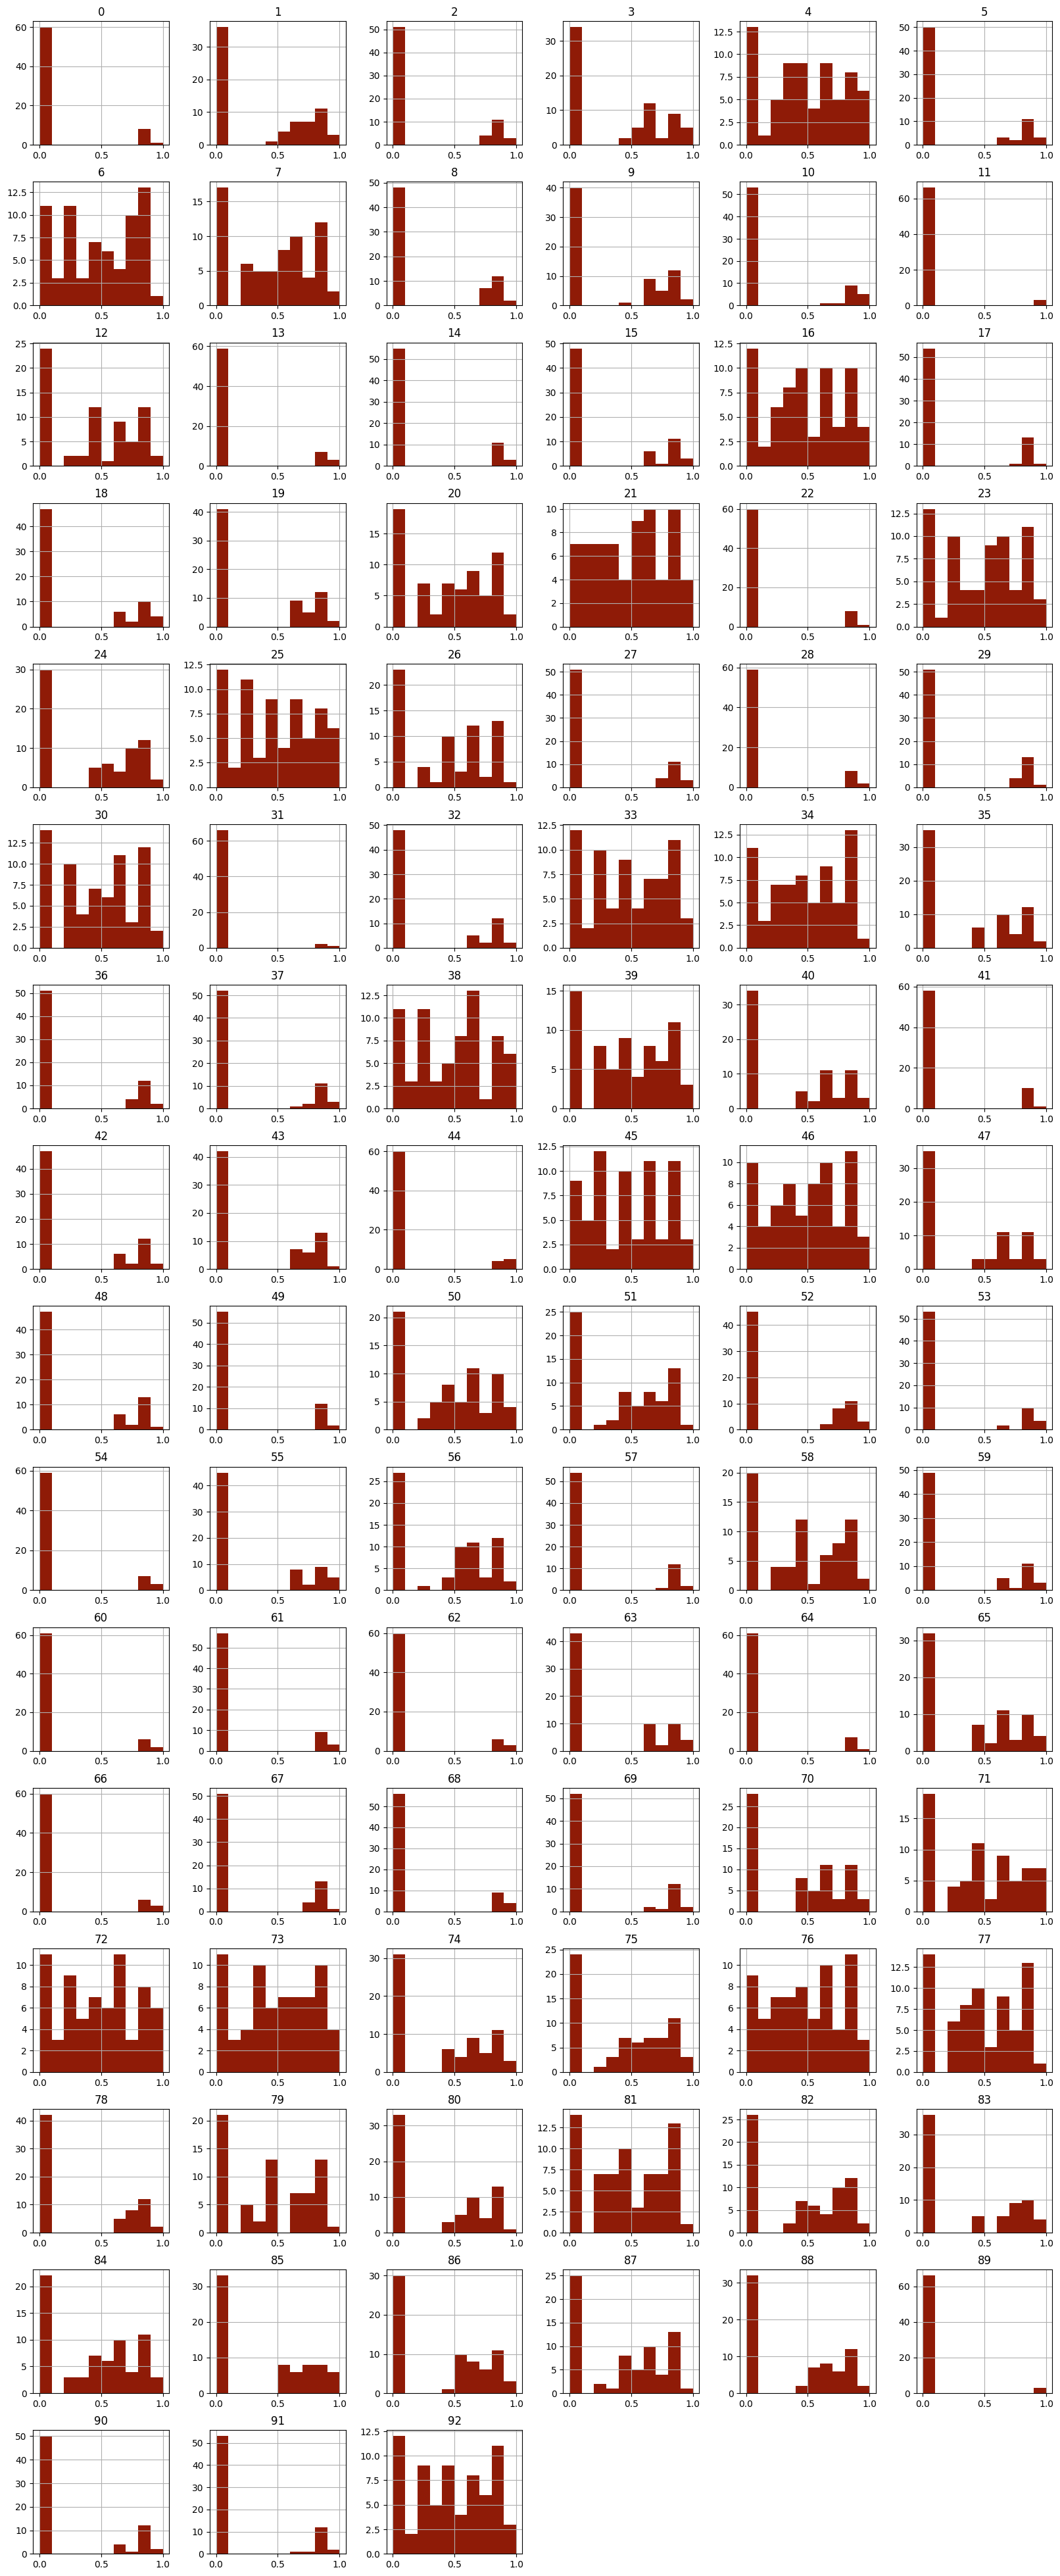

In [16]:
print("Histogram of all measured concentrations:")
cps_norm.hist(figsize=(20,50), layout=(16,6)); #.xs(level="Exposure", key="Chlorine, high")

In [17]:
pca = PCA()
pca_data = pd.DataFrame(
    pca.fit_transform(cps_norm), 
    index=data_pivot_MSMS.index,
    columns=np.arange(1, cps_norm.shape[0]+1)
    )

#### Leave one out validation

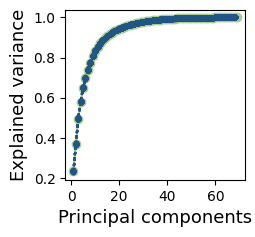

In [18]:
plt.figure(figsize=(3,2.5))

#Leave one out validation
plt.plot(pd.Series(np.cumsum(pca.explained_variance_ratio_), index=np.arange(1, len(pca.explained_variance_ratio_)+1)), marker='o', color='#A5CD90')

for leaveout in cps_norm.index:
    pca = pca.fit(cps_norm.drop(leaveout))
    plt.plot(pd.Series(np.cumsum(pca.explained_variance_ratio_), index=np.arange(1, len(pca.explained_variance_ratio_)+1)), alpha=.4, ls=':', marker='.', color='#215584')
    
plt.xlabel("Principal components", fontsize = 13)
plt.ylabel("Explained variance", fontsize = 13)
plt.gcf().subplots_adjust(bottom=0.2, left = 0.3)

#### Leave one group out validation

In [19]:
test_norm = (cps_norm
               .reset_index()
               .drop(columns=['Source'])
               .loc[cps_norm.reset_index()['Exposure'].str.contains('Household bleach|Pool bleach|Chlorine, high|Chlorine, long|Chlorine, short')] #|Concentrated bleach|
               .pivot_table(index=['Source2', 'Exposure', 'Plant', 'N'])
              )

test_norm

0         1         2         3   \
Source2    Exposure         Plant    N                                      
Bleach low Household bleach Euonymus 1  0.0  0.551429  0.000000  0.000000   
                                     2  0.0  0.599416  0.000000  0.000000   
                                     3  0.0  0.409867  0.000000  0.000000   
                            Grass    1  0.0  0.600094  0.000000  0.000000   
                                     2  0.0  0.677424  0.000000  0.000000   
...                                     ...       ...       ...       ...   
Cl         Chlorine, short  Nettle   2  0.0  0.800004  0.000000  0.000000   
                                     3  0.0  0.800018  0.000000  0.000000   
                                     4  0.0  0.000000  0.800169  0.553736   
                                     5  0.0  0.000000  0.800068  0.000000   
                                     6  0.0  0.000000  0.800019  0.508398   

                                              4         5         6   \
Source2    Exposure         Plant    N                                 
Bleach low Household bleach Euonymus 1  0.808287  0.800963  0.706218   
                                     2  0.772715  0.814017  0.802751   
                                     3  0.698395  0.704394  0.439586   
                            Grass    1  0.772854  0.831279  0.828787   
                                     2  0.813627  0.845162  0.816936   
...                                          ...       ...       ...   
Cl         Chlorine, short  Nettle   2  0.323873  0.000000  0.528285   
                                     3  0.373367  0.000000  0.459302   
                                     4  0.000000  0.000000  0.839355   
                                     5  0.000000  0.000000  0.863251   
                                     6  0.000000  0.000000  0.839234   

                                              7         8         9   ...  \
Source2    Exposure         Plant    N                                ...   
Bleach low Household bleach Euonymus 1  0.265068  0.000000  0.000000  ...   
                                     2  0.437273  0.000000  0.000000  ...   
                                     3  0.466763  0.000000  0.000000  ...   
                            Grass    1  0.000000  0.000000  0.000000  ...   
                                     2  0.633883  0.000000  0.000000  ...   
...                                          ...       ...       ...  ...   
Cl         Chlorine, short  Nettle   2  0.751092  0.800215  0.000000  ...   
                                     3  0.648417  0.792627  0.000000  ...   
                                     4  0.586687  0.000000  0.669360  ...   
                                     5  0.825914  0.000000  0.607478  ...   
                                     6  0.805339  0.000000  0.000000  ...   

                                              83        84        85  \
Source2    Exposure         Plant    N                                 
Bleach low Household bleach Euonymus 1  0.714518  0.000000  0.000000   
                                     2  0.660829  0.561394  0.000000   
                                     3  0.747804  0.000000  0.000000   
                            Grass    1  0.702490  0.541389  0.000000   
                                     2  0.773788  0.600741  0.000000   
...                                          ...       ...       ...   
Cl         Chlorine, short  Nettle   2  0.000000  0.472023  0.000000   
                                     3  0.000000  0.415872  0.000000   
                                     4  0.000000  0.601135  0.956050   
                                     5  0.000000  0.804824  0.987418   
                                     6  0.000000  0.823430  0.924112   

                                              86        87        88   89  \
Source2    Exposure         Plant    N                                      
Bleach lo

In [20]:
pca2 = PCA()
pca_data2 = pd.DataFrame(
    pca2.fit_transform(test_norm), 
    index=test_norm.index,
    columns=np.arange(1, test_norm.shape[0]+1)
    )

pca_data2

1         2         3   \
Source2    Exposure         Plant    N                                 
Bleach low Household bleach Euonymus 1  1.902291 -1.414100  1.002158   
                                     2  1.968165 -1.155623  1.612894   
                                     3  1.832155 -0.977390  1.017193   
                            Grass    1  1.772276 -1.302065  1.894510   
                                     2  1.776236 -1.520837  1.857335   
...                                          ...       ...       ...   
Cl         Chlorine, short  Nettle   2 -1.673964  0.827447  1.291743   
                                     3 -1.420562  0.902729  1.298784   
                                     4  0.012052  1.623715 -1.496957   
                                     5  0.270883  1.572774 -1.350968   
                                     6 -0.034459  1.607624 -1.338191   

                                              4         5         6   \
Source2    Exposure         Plant    N                                 
Bleach low Household bleach Euonymus 1 -0.046483 -0.158284  0.211724   
                                     2  0.493590  0.604984 -0.539286   
                                     3 -0.034116  0.029677  0.205218   
                            Grass    1  0.553719  0.777873 -0.877378   
                                     2  0.530826  0.737656 -0.842681   
...                                          ...       ...       ...   
Cl         Chlorine, short  Nettle   2 -0.172282  0.388718  0.516348   
                                     3 -0.417850  0.196372  0.402720   
                                     4  1.411092  1.626077 -0.124540   
                                     5  1.315729  1.604893 -0.248900   
                                     6  1.410186  1.563233 -0.168860   

                                              7         8         9   \
Source2    Exposure         Plant    N                                 
Bleach low Household bleach Euonymus 1  0.133148  1.137156  0.892313   
                                     2 -0.146535  0.309708  0.664532   
                                     3  0.659633  0.776639  0.844206   
                            Grass    1  0.088180 -0.373209 -0.068598   
                                     2  0.238255 -0.732382 -0.018173   
...                                          ...       ...       ...   
Cl         Chlorine, short  Nettle   2 -0.558402 -0.935400  0.746740   
                                     3 -0.445574 -0.920269  0.619704   
                                     4 -0.057427 -0.428942  0.309283   
                                     5 -0.182969 -0.515633  0.364084   
                                     6 -0.061586 -0.561750  0.317265   

                                              10  ...        48        49  \
Source2    Exposure         Plant    N            ...                       
Bleach low Household bleach Euonymus 1 -0.558815  ...  0.031661  0.043107   
                                     2 -0.255530  ...  0.034530  0.000423   
                                     3  0.741423  ... -0.046948 -0.005454   
                            Grass    1 -0.158380  ... -0.081249 -0.103994   
                                     2 -0.079035  ...  0.041827  0.113851   
...                                          ...  ...       ...       ...   
Cl         Chlorine, short  Nettle   2  0.165765  ...  0.078670 -0.045878   
                                     3  0.198347  ...  0.012749  0.003298   
                                     4 -0.164753  ... -0.026670  0.131799   
                                     5 -0.121272  ... -0.062006 -0.064105   
                                     6 -0.183780  ...  0.085361 -0.047955   

                                              50        51        52  \
Source2    Exposure         Plant    N                                 
Bleach low Household bleach Euonymus 1  0.002232 -0.020776  0.011748   
                 

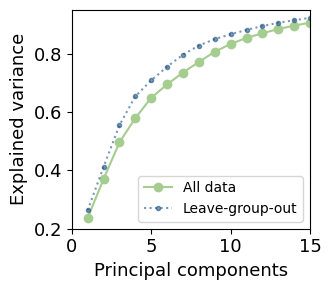

In [21]:
plt.figure(figsize=(3.5,3))

plt.plot(pd.Series(np.cumsum(pca.explained_variance_ratio_), index=np.arange(1, len(pca.explained_variance_ratio_)+1)), marker='o', color='#A5CD90')
plt.plot(pd.Series(np.cumsum(pca2.explained_variance_ratio_), index=np.arange(1, len(pca2.explained_variance_ratio_)+1)), alpha=.6, ls=':', marker='.', color='#215584')

plt.xlabel("Principal components", fontsize = 13)
plt.ylabel("Explained variance", fontsize = 13)

plt.xlim(0, 15)
plt.ylim(0.2, 0.95)

plt.yticks(fontsize=13)
plt.xticks(fontsize=13)

a = plt.legend(['All data', 'Leave-group-out'], fontsize=10)

plt.tight_layout()

#### Score plot

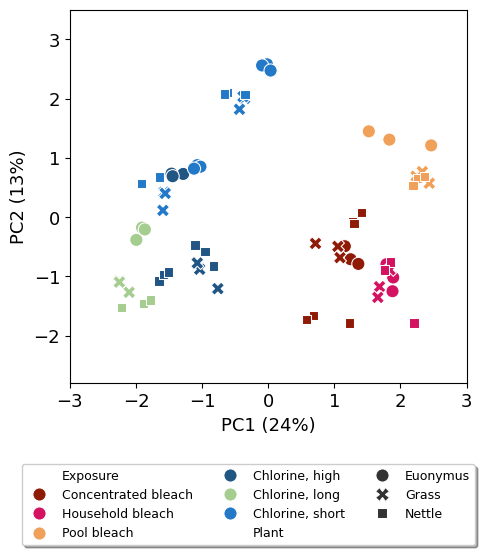

In [22]:
plt.figure(figsize=(5,5.8))

sns.scatterplot(data=pca_data.reset_index(), x=1, y=2, hue='Exposure', style="Plant", palette=mycolors6, s=90, legend=True)
plt.xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0],2):.0%})', fontsize = 13)
plt.ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1],2):.0%})', fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylim(-2.8, 3.5)
plt.xlim(-3, 3)

a = plt.legend(loc='upper center', bbox_to_anchor=(0.45, -0.2),
          fancybox=True, shadow=True, ncol=3, fontsize = 9) #ncol=11 for legend

plt.tight_layout()

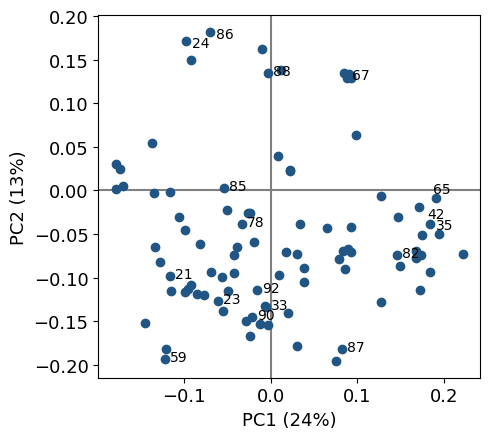

In [23]:
plt.figure(figsize=(5,4.5))

loadings = pd.DataFrame(pca.components_).T[[0, 1]]

plt.axhline(0, color='grey', zorder=1)
plt.axvline(0, color='grey', zorder=1)
plt.scatter(loadings[0], loadings[1], color='#215584')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.0%})', fontsize = 13)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.0%})', fontsize = 13)
for label, x, y in loadings.itertuples():
    if label in (21, 23, 33, 59, 67, 78, 82, 85, 87, 88, 90, 92): #67, 85
        plt.annotate(label, (x, y), xytext=(5, -2), textcoords=('offset pixels', 'offset pixels'), fontsize=10)
    if  x>0.184 and x<0.2: #x>0.2 or
       plt.annotate(label, (x, y), xytext=(-3, 5), textcoords=('offset pixels', 'offset pixels'), fontsize=10)
    if  y>0.17 and x<0: #x>0.2 or
       plt.annotate(label, (x, y), xytext=(6, -6), textcoords=('offset pixels', 'offset pixels'), fontsize=10)

plt.xticks(np.arange(-0.1,0.3, step=0.1), fontsize=13)
plt.yticks(fontsize=13) #(np.arange(-0.6,0.8, step=0.2), fontsize=15)

plt.tight_layout()

### LDA

In [24]:
clf = LinearDiscriminantAnalysis()
clf.fit(X=data_pivot_MSMS, y=data_pivot_MSMS.index.get_level_values('Exposure'))

lda = pd.DataFrame(clf.transform(data_pivot_MSMS)[:,0:2], index=data_pivot_MSMS.index)
lda

0          1
Source Source2     Exposure            Plant    N                      
Bleach Bleach high Concentrated bleach Euonymus 1 -12.986528  11.933316
                                                2 -12.940299  12.539201
                                                3 -12.246480  12.129799
                                       Grass    1 -12.379558  12.641159
                                                2 -12.286349  12.331645
...                                                      ...        ...
Cl     Cl          Chlorine, short     Nettle   2 -22.754303  20.162397
                                                3 -22.306293  20.584073
                                                4 -22.201002  20.575801
                                                5 -21.961024  20.830669
                                                6 -22.753202  20.490164

[69 rows x 2 columns]

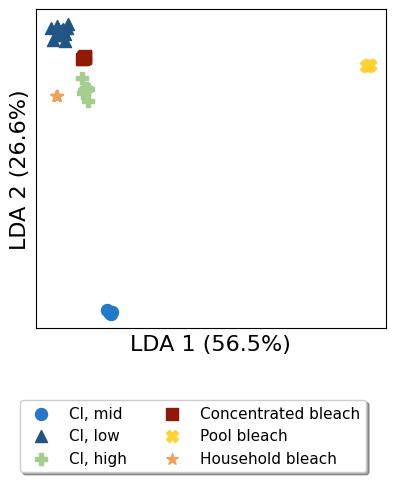

In [25]:
plt.figure(figsize=(5,5.5))

plt.scatter(lda[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, long'], lda[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, long'], color="#2379C7", label='Cl, mid', marker='o', s=75)
plt.scatter(lda[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, short'], lda[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, short'], color="#215584", label='Cl, low', marker='^', s=75)
plt.scatter(lda[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, high'], lda[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, high'],color="#A5CD90", label='Cl, high', marker='P', s=75)
plt.scatter(lda[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Concentrated bleach'], lda[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Concentrated bleach'],color="#8F1B07", label='Concentrated bleach', marker='s', s=75)
plt.scatter(lda[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Pool bleach'], lda[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Pool bleach'],color="#FFD133", label='Pool bleach', marker='X', s=75)
plt.scatter(lda[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Household bleach'], lda[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Household bleach'],  color="#F0A058", label='Household bleach', marker='*', s=75)


plt.xlabel(f'LDA 1 ({clf.explained_variance_ratio_[0]:.01%})', fontsize = 16)
plt.ylabel(f'LDA 2 ({clf.explained_variance_ratio_[1]:.01%})', fontsize = 16)

plt.xticks(ticks=[])
plt.yticks(ticks=[])

a = plt.legend(loc='upper center', bbox_to_anchor=(0.45, -0.2),
         fancybox=True, shadow=True, ncol=2, fontsize = 11)

plt.gcf().subplots_adjust(bottom=0.3, left = 0.2)

### PCA & LDA

In [26]:
clf = LinearDiscriminantAnalysis()
pca_data3 = pca_data.loc[:, 0:18]

clf.fit(X=pca_data3, y=pca_data3.index.get_level_values('Exposure'))

lda3 = pd.DataFrame(clf.transform(pca_data3)[:,0:2], index=pca_data3.index)
lda3

0         1
Source Source2     Exposure            Plant    N                     
Bleach Bleach high Concentrated bleach Euonymus 1  11.572843 -0.047886
                                                2  11.180461 -1.978686
                                                3  13.402560 -1.906806
                                       Grass    1  10.336808 -2.815781
                                                2  12.619865 -0.616577
...                                                      ...       ...
Cl     Cl          Chlorine, short     Nettle   2  -7.250570  6.127048
                                                3  -5.657141  5.358361
                                                4  -6.676323  6.644499
                                                5  -4.893629  4.990724
                                                6  -6.683942  7.280312

[69 rows x 2 columns]

#### 2D with 6 groups

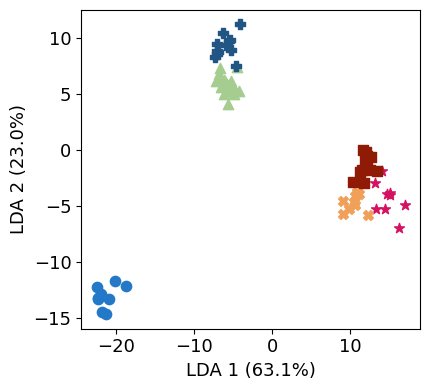

In [27]:
plt.figure(figsize=(4.4,4))

plt.scatter(lda3[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, short'], lda3[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, short'], color="#A5CD90", label='Cl, low', marker='^', s=55)
plt.scatter(lda3[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, long'], lda3[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, long'], color="#2379C7", label='Cl, mid', marker='o', s=55)
plt.scatter(lda3[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, high'], lda3[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, high'],color="#215584", label='Cl, high', marker='P', s=55)
plt.scatter(lda3[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Household bleach'], lda3[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Household bleach'],  color="#D41262", label='Household bleach', marker='*', s=55)
plt.scatter(lda3[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Pool bleach'], lda3[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Pool bleach'],color="#F0A058", label='Pool bleach', marker='X', s=50)
plt.scatter(lda3[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Concentrated bleach'], lda3[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Concentrated bleach'],color="#8F1B07", label='Concentrated bleach', marker='s', s=50)

plt.xlabel(f'LDA 1 ({clf.explained_variance_ratio_[0]:.01%})', fontsize = 13)
plt.ylabel(f'LDA 2 ({clf.explained_variance_ratio_[1]:.01%})', fontsize = 13)

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

plt.tight_layout()

#### Hist with 2 groups

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X=pca_data.loc[:, 0:5], y=pca_data.loc[:, 0:5].index.get_level_values('Source'))

lda2 = pd.DataFrame(clf.transform(pca_data.loc[:, 0:5])[:,0:1], index=pca_data.loc[:, 0:5].index)
lda2

0
Source Source2     Exposure            Plant    N          
Bleach Bleach high Concentrated bleach Euonymus 1 -4.503182
                                                2 -4.995870
                                                3 -5.278569
                                       Grass    1 -3.047095
                                                2 -4.224850
...                                                     ...
Cl     Cl          Chlorine, short     Nettle   2  5.803754
                                                3  4.961862
                                                4  5.001166
                                                5  4.263660
                                                6  5.107961

[69 rows x 1 columns]

In [29]:
def plot_hist(data, n, color, binwidth=.5):
    plt.hist(
        data, 
        bins=np.arange(np.floor(data.min()), data.max()+binwidth, binwidth),
        weights=np.repeat(1/n, len(data)),
        color=color
    )

/tmp/ipykernel_9857/251093671.py:9: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(lda2[0][np.array(data_pivot_MSMS.index.get_level_values('Source')) == 'Cl'], fill=True, bw=1, color='#6DB290', label='Cl')
/tmp/ipykernel_9857/251093671.py:10: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(lda2[0][np.array(data_pivot_MSMS.index.get_level_values('Source')) == 'Bleach'], fill=True, bw=1, color='#8F1B07', label='Bleach')


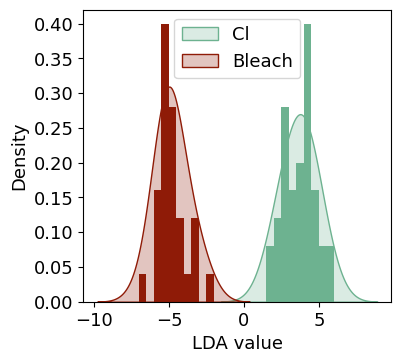

In [30]:
plt.figure(figsize=(4.4,4))

plt.xlabel('LDA value', fontsize = 13)
plt.ylabel('Density', fontsize = 13)

plot_hist(lda2[0][lda2[0].index.get_level_values('Source') == 'Cl'].values, 25, color='#6DB290')
plot_hist(lda2[0][lda2[0].index.get_level_values('Source') == 'Bleach'].values, 25, color='#8F1B07')

sns.kdeplot(lda2[0][np.array(data_pivot_MSMS.index.get_level_values('Source')) == 'Cl'], fill=True, bw=1, color='#6DB290', label='Cl')
sns.kdeplot(lda2[0][np.array(data_pivot_MSMS.index.get_level_values('Source')) == 'Bleach'], fill=True, bw=1, color='#8F1B07', label='Bleach')

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

plt.legend(fontsize = 13)

plt.gcf().subplots_adjust(left=0.20, bottom=0.15)

##### LR

In [31]:
from scipy import stats
def likelihood(lda_score: float):
    kernel_Cl = stats.gaussian_kde(lda2[0][np.array(data_pivot_MSMS.index.get_level_values('Source')) == 'Cl'].values)
    kernel_Bleach = stats.gaussian_kde(lda2[0][np.array(data_pivot_MSMS.index.get_level_values('Source')) == 'Bleach'].values)
    return kernel_Cl(lda_score)/kernel_Bleach(lda_score)

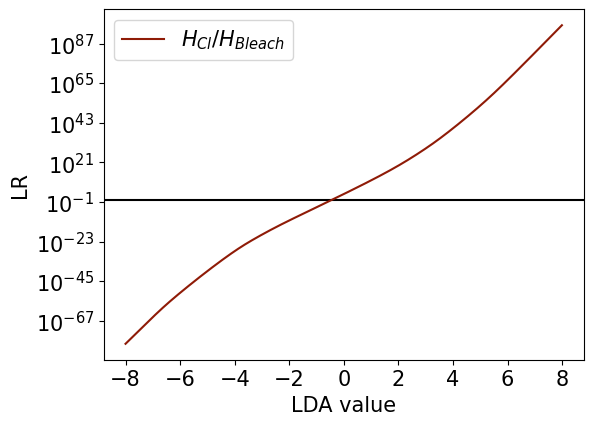

In [32]:
x = np.arange(-8, 8, 0.01)
y = [likelihood(x_) for x_ in np.arange(-8, 8, .01)]

fig, ax = plt.subplots()
ax.axhline(1, color='black')
ax.plot(x, y, label=r'$H_{Cl} / H_{Bleach}$')

ax.set_yscale('log')

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

ax.set_xlabel('LDA value', fontsize=15)
ax.set_ylabel('LR', fontsize=15)
plt.legend(fontsize = 15)

plt.gcf().subplots_adjust(bottom=0.15, left = 0.15)

In [33]:
y_bound_log = np.clip(np.log(y), -2, 2)
y_log = np.log(y)

In [34]:
y_bound = [10**x for x in y_bound_log]

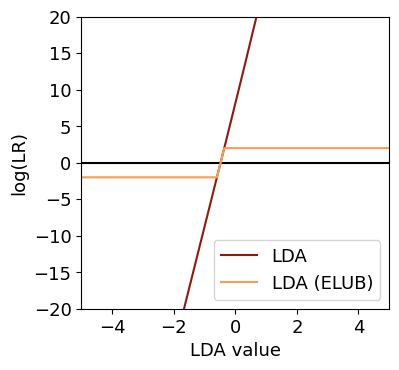

In [35]:
x = np.arange(-8, 8, 0.01)
y = [likelihood(x_) for x_ in np.arange(-8, 8, .01)]
y_ELUB_log = y_bound_log 

fig, ax = plt.subplots(figsize=(4.4,4))
ax.axhline(0, color='black')
ax.plot(x, y_log, label='LDA', color="#8F1B07") #r'$H_{Cl} / H_{Bleach}$')
ax.plot(x, y_ELUB_log, label='LDA (ELUB)', color="#F0A058") #r'$H_{Cl} / H_{Bleach}$ (ELUB)')

ax.set_ylim(-20, 20)
ax.set_xlim(-5,5)

plt.yticks(fontsize=13)
plt.xticks(fontsize=13)

ax.set_xlabel('LDA value', fontsize=13)
ax.set_ylabel('log(LR)', fontsize=13)
plt.legend(fontsize = 13)

plt.gcf().subplots_adjust(left=0.20, bottom=0.15)

##### Tippet with N bound

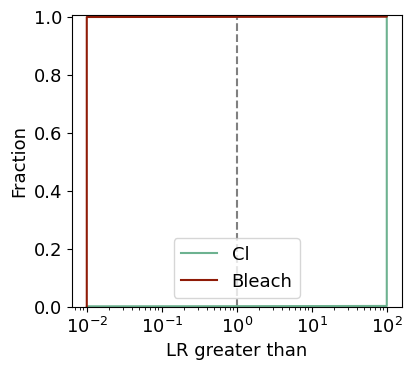

In [36]:
plt.figure(figsize=(4.4,4))

def cum_and_norm(x): return np.cumsum(x)/sum(x)

kde_Cl = gaussian_kde(lda2[0][np.array(data_pivot_MSMS.index.get_level_values('Source')) == 'Cl'], bw_method=1)
kde_Bleach = gaussian_kde(lda2[0][np.array(data_pivot_MSMS.index.get_level_values('Source')) == 'Bleach'], bw_method=1)
x_range = np.arange(-8, 8, 0.01)

plt.axvline(x=1, color='grey',  ls='--')
plt.plot(y_bound, cum_and_norm([kde_Cl(x_) for x_ in x_range]), label='Cl', color='#6DB290')
plt.plot(y_bound, cum_and_norm([kde_Bleach(x_) for x_ in x_range]), label='Bleach', color='#8F1B07')
plt.xlabel('LR greater than', fontsize = 13)
plt.ylabel('Fraction', fontsize = 13)
plt.xscale('log')

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)
plt.ylim(0, 1.007)

plt.legend(fontsize=13)
plt.gcf().subplots_adjust(left=0.15, bottom=0.15)

##### Tippett

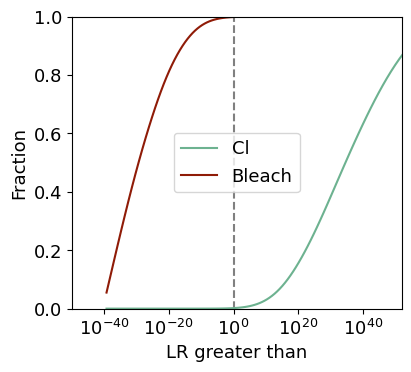

In [37]:
plt.figure(figsize=(4.4,4))

def cum_and_norm(x): return np.cumsum(x)/sum(x)

kde_Cl = gaussian_kde(lda2[0][np.array(data_pivot_MSMS.index.get_level_values('Source')) == 'Cl'], bw_method=1)
kde_Bleach = gaussian_kde(lda2[0][np.array(data_pivot_MSMS.index.get_level_values('Source')) == 'Bleach'], bw_method=1)
x_range = np.arange(-5, 6, .1)

plt.axvline(x=1, color='grey',  ls='--')
plt.plot([likelihood(x_) for x_ in x_range], cum_and_norm([kde_Cl(x_) for x_ in x_range]), label='Cl', color='#6DB290')
plt.plot([likelihood(x_) for x_ in x_range], cum_and_norm([kde_Bleach(x_) for x_ in x_range]), label='Bleach', color='#8F1B07')
plt.xlabel('LR greater than', fontsize = 13)
plt.ylabel('Fraction', fontsize = 13)
plt.xscale('log')
plt.xlim(1e-50, 1e52)
plt.xticks([1e-40, 1e-20, 1e0, 1e20, 1e40])

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)
plt.ylim(0, 1)

plt.legend(fontsize=13)
plt.gcf().subplots_adjust(left=0.15, bottom=0.15)

### LDA train-test

#### Split data

In [38]:
data_train4 = (data_pivot_MSMS
               .reset_index()
               .loc[data_pivot_MSMS.reset_index()['Plant'].str.contains('Nettle|Grass')]
               .pivot_table(index=['Source','Source2', 'Exposure', 'Plant', 'N'])
              )

data_test4 = (data_pivot_MSMS
               .reset_index()
               .loc[data_pivot_MSMS.reset_index()['Plant'].str.contains('Euonymus')]
               .pivot_table(index=['Source','Source2', 'Exposure', 'Plant', 'N'])
              )

data_train5 = (data_pivot_MSMS
               .reset_index()
               .loc[data_pivot_MSMS.reset_index()['Plant'].str.contains('Euonymus|Nettle')]
               .pivot_table(index=['Source','Source2', 'Exposure', 'Plant', 'N'])
              )

data_test5 = (data_pivot_MSMS
               .reset_index()
               .loc[data_pivot_MSMS.reset_index()['Plant'].str.contains('Grass')]
               .pivot_table(index=['Source','Source2', 'Exposure', 'Plant', 'N'])
              )

data_train6 = (data_pivot_MSMS
               .reset_index()
               .loc[data_pivot_MSMS.reset_index()['Plant'].str.contains('Euonymus|Grass')]
               .pivot_table(index=['Source','Source2', 'Exposure', 'Plant', 'N'])
              )

data_test6 = (data_pivot_MSMS
               .reset_index()
               .loc[data_pivot_MSMS.reset_index()['Plant'].str.contains('Nettle')]
               .pivot_table(index=['Source','Source2', 'Exposure', 'Plant', 'N'])
              )

#### Normalize

In [39]:
data_train_norm4 = pd.DataFrame(QuantileTransformer(n_quantiles=6).fit_transform(data_train4), index=data_train4.index) # QuantileTransformer(n_quantiles=6), StandardScaler()
data_test_norm4 = pd.DataFrame(QuantileTransformer(n_quantiles=6).fit_transform(data_test4), index=data_test4.index)
data_train_norm5 = pd.DataFrame(QuantileTransformer(n_quantiles=6).fit_transform(data_train5), index=data_train5.index) # QuantileTransformer(n_quantiles=6), StandardScaler()
data_test_norm5 = pd.DataFrame(QuantileTransformer(n_quantiles=6).fit_transform(data_test5), index=data_test5.index)
data_train_norm6 = pd.DataFrame(QuantileTransformer(n_quantiles=6).fit_transform(data_train6), index=data_train6.index) # QuantileTransformer(n_quantiles=6), StandardScaler()
data_test_norm6 = pd.DataFrame(QuantileTransformer(n_quantiles=6).fit_transform(data_test6), index=data_test6.index)
data_train_norm4

0         1         2   \
Source Source2     Exposure            Plant  N                                 
Bleach Bleach high Concentrated bleach Grass  1  0.809282  0.000000  0.000000   
                                              2  0.000000  0.000000  0.000000   
                                              3  0.813103  0.000000  0.000000   
                                       Nettle 1  0.806103  0.000000  0.000000   
                                              2  0.828032  0.000000  0.000000   
...                                                   ...       ...       ...   
Cl     Cl          Chlorine, short     Nettle 2  0.000000  0.786172  0.000000   
                                              3  0.000000  0.800006  0.000000   
                                              4  0.000000  0.000000  0.800196   
                                              5  0.000000  0.000000  0.800094   
                                              6  0.000000  0.000000  0.800046   

                                                       3         4    5   \
Source Source2     Exposure            Plant  N                            
Bleach Bleach high Concentrated bleach Grass  1  0.000000  0.378854  0.0   
                                              2  0.000000  0.446614  0.0   
                                              3  0.000000  0.470766  0.0   
                                       Nettle 1  0.593657  0.616559  0.0   
                                              2  0.542111  0.633448  0.0   
...                                                   ...       ...  ...   
Cl     Cl          Chlorine, short     Nettle 2  0.000000  0.348972  0.0   
                                              3  0.000000  0.400221  0.0   
                                              4  0.523000  0.000000  0.0   
                                              5  0.000000  0.000000  0.0   
                                              6  0.479326  0.000000  0.0   

                                                       6         7         8   \
Source Source2     Exposure            Plant  N                                 
Bleach Bleach high Concentrated bleach Grass  1  0.005031  0.000000  0.000000   
                                              2  0.066990  0.000000  0.000000   
                                              3  0.030264  0.000000  0.000000   
                                       Nettle 1  0.184593  0.031737  0.000000   
                                              2  0.126687  0.040092  0.000000   
...                                                   ...       ...       ...   
Cl     Cl          Chlorine, short     Nettle 2  0.400919  0.685285  0.856335   
                                              3  0.349719  0.591636  0.812816   
                                              4  0.828801  0.421819  0.000000   
                                              5  0.854266  0.821667  0.000000   
                                              6  0.828671  0.800590  0.000000   

                                                       9   ...        83  \
Source Source2     Exposure            Plant  N            ...             
Bleach Bleach high Concentrated bleach Grass  1  0.819434  ...  0.496979   
                                              2  0.000000  ...  0.659712   
                                              3  0.801397  ...  0.529322   
                                       Nettle 1  0.801810  ...  0.802786   
                                              2  0.801409  ...  0.807622   
...                                                   ...  ...       ...   
Cl     Cl          Chlorine, short     Nettle 2  0.000000  ...  0.000000   
                                              3  0.000000  ...  0.000000   
                                              4  0.677710  ...  0.000000   
                                              5  0.610116  ...  0.000000   
                                              

#### LDA training set

In [40]:
def plot_hist(data, n, color, binwidth=0.5):
    plt.hist(
        data, 
        bins=np.arange(np.floor(data.min()), data.max()+binwidth, binwidth),
        weights=np.repeat(1/n, len(data)),
        color=color
    )

##### #4

In [41]:
clf = LinearDiscriminantAnalysis()
clf.fit(X=data_train_norm4, y=data_train_norm4.index.get_level_values('Source'))

lda_train = pd.DataFrame(clf.transform(data_train_norm4)[:,0:1], index=data_train_norm4.index)
lda_train

0
Source Source2     Exposure            Plant  N           
Bleach Bleach high Concentrated bleach Grass  1 -16.598080
                                              2 -16.868945
                                              3 -18.696627
                                       Nettle 1 -16.789774
                                              2 -18.653802
...                                                    ...
Cl     Cl          Chlorine, short     Nettle 2  15.328167
                                              3  12.923538
                                              4  12.903350
                                              5  13.598441
                                              6  14.939975

[48 rows x 1 columns]

/tmp/ipykernel_9857/260728982.py:9: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(lda_train[0][np.array(data_train4.index.get_level_values('Source')) == 'Cl'], fill=True, bw=1, color='#6DB290', label='Cl')
/tmp/ipykernel_9857/260728982.py:10: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(lda_train[0][np.array(data_train4.index.get_level_values('Source')) == 'Bleach'], fill=True, bw=1, color='#8F1B07', label='Bleach')


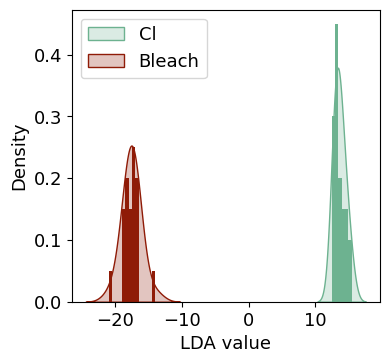

In [42]:
plt.figure(figsize=(4.4,4))

plt.xlabel('LDA value', fontsize = 13)
plt.ylabel('Density', fontsize = 13)

plot_hist(lda_train[0][lda_train[0].index.get_level_values('Source') == 'Cl'].values, 20, color='#6DB290')
plot_hist(lda_train[0][lda_train[0].index.get_level_values('Source') == 'Bleach'].values, 20, color='#8F1B07')

sns.kdeplot(lda_train[0][np.array(data_train4.index.get_level_values('Source')) == 'Cl'], fill=True, bw=1, color='#6DB290', label='Cl')
sns.kdeplot(lda_train[0][np.array(data_train4.index.get_level_values('Source')) == 'Bleach'], fill=True, bw=1, color='#8F1B07', label='Bleach')

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

plt.legend(fontsize = 13)

plt.gcf().subplots_adjust(left=0.20, bottom=0.15)

##### #5

In [43]:
def plot_hist(data, n, color, binwidth=1):
    plt.hist(
        data, 
        bins=np.arange(np.floor(data.min()), data.max()+binwidth, binwidth),
        weights=np.repeat(1/n, len(data)),
        color=color
    )

In [44]:
clf = LinearDiscriminantAnalysis()
clf.fit(X=data_train_norm5, y=data_train_norm5.index.get_level_values('Source'))

lda_train = pd.DataFrame(clf.transform(data_train_norm5)[:,0:1], index=data_train_norm5.index)
lda_train

0
Source Source2     Exposure            Plant    N           
Bleach Bleach high Concentrated bleach Euonymus 1 -28.588472
                                                2 -28.592459
                                                3 -29.421210
                                       Nettle   1 -27.222917
                                                2 -30.593959
...                                                      ...
Cl     Cl          Chlorine, short     Nettle   2  23.193787
                                                3  22.357815
                                                4  21.899617
                                                5  22.531761
                                                6  23.045949

[48 rows x 1 columns]

/tmp/ipykernel_9857/3762424966.py:9: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(lda_train[0][np.array(data_train5.index.get_level_values('Source')) == 'Cl'], fill=True, bw=1, color='#6DB290', label='Cl')
/tmp/ipykernel_9857/3762424966.py:10: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(lda_train[0][np.array(data_train5.index.get_level_values('Source')) == 'Bleach'], fill=True, bw=1, color='#8F1B07', label='Bleach')


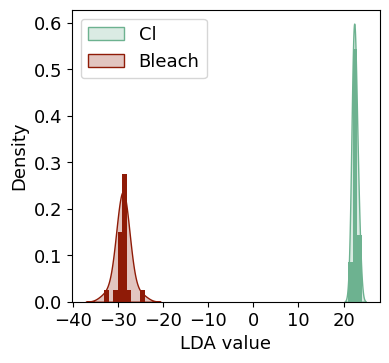

In [45]:
plt.figure(figsize=(4.4,4))

plt.xlabel('LDA value', fontsize = 13)
plt.ylabel('Density', fontsize = 13)

plot_hist(lda_train[0][lda_train[0].index.get_level_values('Source') == 'Cl'].values, 35, color='#6DB290')
plot_hist(lda_train[0][lda_train[0].index.get_level_values('Source') == 'Bleach'].values, 40, color='#8F1B07')

sns.kdeplot(lda_train[0][np.array(data_train5.index.get_level_values('Source')) == 'Cl'], fill=True, bw=1, color='#6DB290', label='Cl')
sns.kdeplot(lda_train[0][np.array(data_train5.index.get_level_values('Source')) == 'Bleach'], fill=True, bw=1, color='#8F1B07', label='Bleach')

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

plt.legend(fontsize = 13)

plt.gcf().subplots_adjust(left=0.20, bottom=0.15)

##### #6

In [46]:
clf = LinearDiscriminantAnalysis()
clf.fit(X=data_train_norm6, y=data_train_norm6.index.get_level_values('Source'))

lda_train6 = pd.DataFrame(clf.transform(data_train_norm6)[:,0:1], index=data_train_norm6.index)
lda_train6

0
Source Source2     Exposure            Plant    N           
Bleach Bleach high Concentrated bleach Euonymus 1 -13.032172
                                                2 -12.816075
                                                3 -14.729500
                                       Grass    1 -12.240829
                                                2 -15.078663
...                                                      ...
Cl     Cl          Chlorine, short     Grass    2  10.482468
                                                3   9.933471
                                                4   9.032521
                                                5  10.927973
                                                6  10.625072

[42 rows x 1 columns]

/tmp/ipykernel_9857/2863628247.py:9: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(lda_train6[0][np.array(data_train6.index.get_level_values('Source')) == 'Cl'], fill=True, bw=1, color='#6DB290', label='Cl')
/tmp/ipykernel_9857/2863628247.py:10: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(lda_train6[0][np.array(data_train6.index.get_level_values('Source')) == 'Bleach'], fill=True, bw=1, color='#8F1B07', label='Bleach')


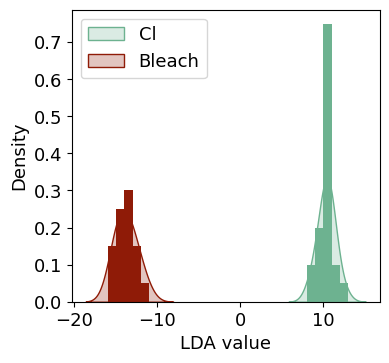

In [47]:
plt.figure(figsize=(4.4,4))

plt.xlabel('LDA value', fontsize = 13)
plt.ylabel('Density', fontsize = 13)

plot_hist(lda_train6[0][lda_train6[0].index.get_level_values('Source') == 'Cl'].values, 20, color='#6DB290')
plot_hist(lda_train6[0][lda_train6[0].index.get_level_values('Source') == 'Bleach'].values, 20, color='#8F1B07')

sns.kdeplot(lda_train6[0][np.array(data_train6.index.get_level_values('Source')) == 'Cl'], fill=True, bw=1, color='#6DB290', label='Cl')
sns.kdeplot(lda_train6[0][np.array(data_train6.index.get_level_values('Source')) == 'Bleach'], fill=True, bw=1, color='#8F1B07', label='Bleach')

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

plt.legend(fontsize = 13)

plt.gcf().subplots_adjust(left=0.20, bottom=0.15)

#### LDA test set

##### #4

In [48]:
def plot_hist(data, n, color, binwidth=2):
    plt.hist(
        data, 
        bins=np.arange(np.floor(data.min()), data.max()+binwidth, binwidth),
        weights=np.repeat(1/n, len(data)),
        color=color
    )

In [49]:
clf = LinearDiscriminantAnalysis()
clf.fit(X=data_train_norm4, y=data_train_norm4.index.get_level_values('Source'))

lda_test4 = pd.DataFrame(clf.transform(data_test_norm4)[:,0:1], index=data_test_norm4.index)
lda_test4

0
Source Source2     Exposure            Plant    N           
Bleach Bleach high Concentrated bleach Euonymus 1 -13.534255
                                                2  -8.997321
                                                3 -20.670239
       Bleach low  Household bleach    Euonymus 1  -2.869217
                                                2 -26.444230
...                                                      ...
Cl     Cl          Chlorine, short     Euonymus 2   6.510679
                                                3   6.515922
                                                4  13.469131
                                                5  12.528875
                                                6   7.972687

[21 rows x 1 columns]

/tmp/ipykernel_9857/484033608.py:9: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(lda_test4[0][np.array(lda_test4.index.get_level_values('Source')) == 'Cl'], fill=True, bw=1, color='#6DB290', label='Cl')
/tmp/ipykernel_9857/484033608.py:10: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(lda_test4[0][np.array(lda_test4.index.get_level_values('Source')) == 'Bleach'], fill=True, bw=1, color='#8F1B07', label='Bleach')


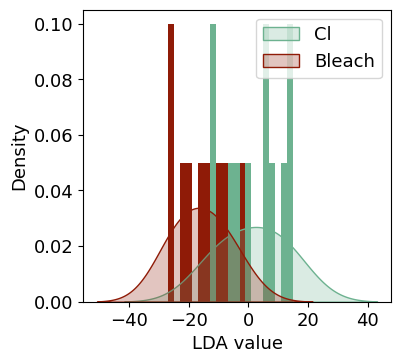

In [50]:
plt.figure(figsize=(4.4,4))

plt.xlabel('LDA value', fontsize = 13)
plt.ylabel('Density', fontsize = 13)

plot_hist(lda_test4[0][lda_test4[0].index.get_level_values('Source') == 'Cl'].values, 20, color='#6DB290')
plot_hist(lda_test4[0][lda_test4[0].index.get_level_values('Source') == 'Bleach'].values, 20, color='#8F1B07')

sns.kdeplot(lda_test4[0][np.array(lda_test4.index.get_level_values('Source')) == 'Cl'], fill=True, bw=1, color='#6DB290', label='Cl')
sns.kdeplot(lda_test4[0][np.array(lda_test4.index.get_level_values('Source')) == 'Bleach'], fill=True, bw=1, color='#8F1B07', label='Bleach')

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

plt.legend(fontsize = 13)

plt.gcf().subplots_adjust(left=0.20, bottom=0.15)

##### #5

In [51]:
def plot_hist(data, n, color, binwidth=4):
    plt.hist(
        data, 
        bins=np.arange(np.floor(data.min()), data.max()+binwidth, binwidth),
        weights=np.repeat(1/n, len(data)),
        color=color
    )

In [52]:
clf = LinearDiscriminantAnalysis()
clf.fit(X=data_train_norm5, y=data_train_norm5.index.get_level_values('Source'))

lda_test5 = pd.DataFrame(clf.transform(data_test_norm5)[:,0:1], index=data_test_norm5.index)
lda_test5

0
Source Source2     Exposure            Plant N           
Bleach Bleach high Concentrated bleach Grass 1 -30.264120
                                             2 -34.285164
                                             3 -20.520818
       Bleach low  Household bleach    Grass 1 -24.602152
                                             2 -25.801314
...                                                   ...
Cl     Cl          Chlorine, short     Grass 2  25.670539
                                             3  21.368860
                                             4  28.352403
                                             5  21.116219
                                             6  27.281979

[21 rows x 1 columns]

/tmp/ipykernel_9857/2402398016.py:9: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(lda_test5[0][np.array(lda_test5.index.get_level_values('Source')) == 'Cl'], fill=True, bw=1, color='#6DB290', label='Cl')
/tmp/ipykernel_9857/2402398016.py:10: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.8`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(lda_test5[0][np.array(lda_test5.index.get_level_values('Source')) == 'Bleach'], fill=True, bw=0.8, color='#8F1B07', label='Bleach')


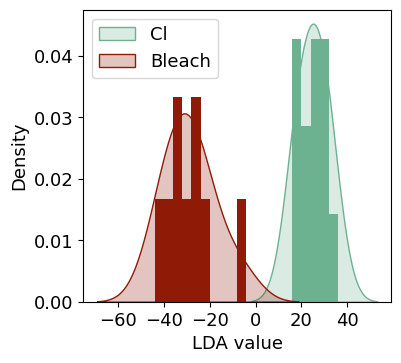

In [53]:
plt.figure(figsize=(4.4,4))

plt.xlabel('LDA value', fontsize = 13)
plt.ylabel('Density', fontsize = 13)

plot_hist(lda_test5[0][lda_test5[0].index.get_level_values('Source') == 'Cl'].values, 70, color='#6DB290')
plot_hist(lda_test5[0][lda_test5[0].index.get_level_values('Source') == 'Bleach'].values, 60, color='#8F1B07')

sns.kdeplot(lda_test5[0][np.array(lda_test5.index.get_level_values('Source')) == 'Cl'], fill=True, bw=1, color='#6DB290', label='Cl')
sns.kdeplot(lda_test5[0][np.array(lda_test5.index.get_level_values('Source')) == 'Bleach'], fill=True, bw=0.8, color='#8F1B07', label='Bleach')

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

plt.legend(fontsize = 13)

plt.gcf().subplots_adjust(left=0.20, bottom=0.15)

##### #6

In [54]:
def plot_hist(data, n, color, binwidth=2):
    plt.hist(
        data, 
        bins=np.arange(np.floor(data.min()), data.max()+binwidth, binwidth),
        weights=np.repeat(1/n, len(data)),
        color=color
    )

In [55]:
clf = LinearDiscriminantAnalysis()
clf.fit(X=data_train_norm6, y=data_train_norm6.index.get_level_values('Source'))

lda_test6 = pd.DataFrame(clf.transform(data_test_norm6)[:,0:1], index=data_test_norm6.index)
lda_test6

0
Source Source2     Exposure            Plant  N           
Bleach Bleach high Concentrated bleach Nettle 1 -12.308846
                                              2 -11.879531
                                              3 -17.052697
                                              4 -12.229874
                                              5 -11.750101
...                                                    ...
Cl     Cl          Chlorine, short     Nettle 2  20.850866
                                              3  20.385430
                                              4  16.934300
                                              5  16.063888
                                              6  19.758835

[27 rows x 1 columns]

/tmp/ipykernel_9857/1191736025.py:9: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.8`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(lda_test6[0][np.array(lda_test6.index.get_level_values('Source')) == 'Cl'], fill=True, bw=0.8, color='#6DB290', label='Cl')
/tmp/ipykernel_9857/1191736025.py:10: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(lda_test6[0][np.array(lda_test6.index.get_level_values('Source')) == 'Bleach'], fill=True, bw=1, color='#8F1B07', label='Bleach')


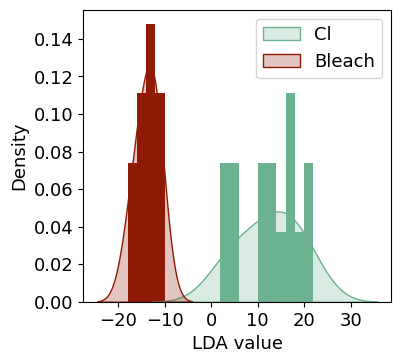

In [56]:
plt.figure(figsize=(4.4,4))

plt.xlabel('LDA value', fontsize = 13)
plt.ylabel('Density', fontsize = 13)

plot_hist(lda_test6[0][lda_test6[0].index.get_level_values('Source') == 'Cl'].values, 27, color='#6DB290')
plot_hist(lda_test6[0][lda_test6[0].index.get_level_values('Source') == 'Bleach'].values, 27, color='#8F1B07')

sns.kdeplot(lda_test6[0][np.array(lda_test6.index.get_level_values('Source')) == 'Cl'], fill=True, bw=0.8, color='#6DB290', label='Cl')
sns.kdeplot(lda_test6[0][np.array(lda_test6.index.get_level_values('Source')) == 'Bleach'], fill=True, bw=1, color='#8F1B07', label='Bleach')

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

plt.legend(fontsize = 13)

plt.gcf().subplots_adjust(left=0.20, bottom=0.15)

#### Calculate LRs

In [57]:
def likelihood(lda_score: float):
    kernel_Cl = stats.gaussian_kde(lda_test6[0][np.array(data_test_norm6.index.get_level_values('Source')) == 'Cl'].values)
    kernel_Bleach = stats.gaussian_kde(lda_test6[0][np.array(data_test_norm6.index.get_level_values('Source')) == 'Bleach'].values)
    return kernel_Cl(lda_score)/kernel_Bleach(lda_score)

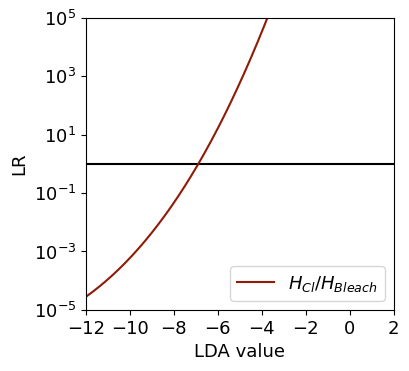

In [58]:
x = np.arange(-20, 20, 0.1)
y_test = [likelihood(x_) for x_ in np.arange(-20, 20, 0.1)]

fig, ax = plt.subplots(figsize=(4.4,4))
ax.axhline(1, color='black')
ax.plot(x, y_test, label=r'$H_{Cl} / H_{Bleach}$')

ax.set_yscale('log')
ax.set_ylim(1e-5, 1e5)
ax.set_xlim(-12, 2)

plt.yticks(fontsize=13)
plt.xticks(fontsize=13)

ax.set_xlabel('LDA value', fontsize=13)
ax.set_ylabel('LR', fontsize=13)
plt.legend(fontsize = 13)

plt.gcf().subplots_adjust(left=0.20, bottom=0.15)

#### Boundaries

In [59]:
kde_calibrator = lir.KDECalibrator(bandwidth='silverman')

In [60]:
kde_calibrator.fit(lda_test6[0].values, (lda_test6[0].reset_index()["Source"] == "Cl").values)

KDECalibrator(bandwidth=<function KDECalibrator.bandwidth_silverman at 0x7fc0f7a86560>)

In [61]:
logreg_calibrator = lir.LogitCalibrator()

In [62]:
bounded_kde_calibrator = lir.ELUBbounder(kde_calibrator)
bounded_logreg_calibrator = lir.ELUBbounder(logreg_calibrator)

ELUB log(LR) bounds for logreg are -1.17 and 1.08
ELUB log(LR) bounds for kde are -1.17 and 1.08


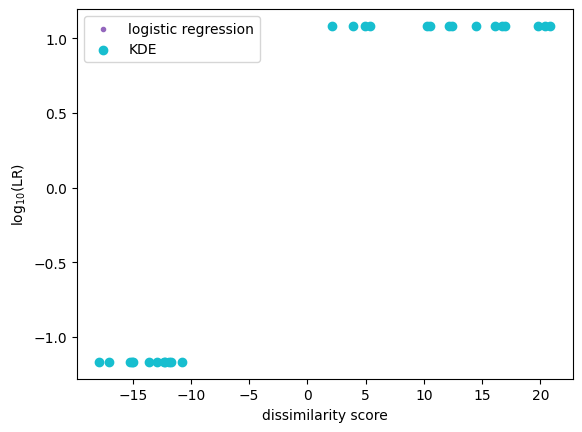

In [63]:
lrs_train_logreg = bounded_logreg_calibrator.fit_transform(lda_test6[0].values, (lda_test6[0].reset_index()["Source"] == "Cl").values)
y = bounded_kde_calibrator.fit_transform(lda_test6[0].values, (lda_test6[0].reset_index()["Source"] == "Cl").values)

plt.scatter(lda_test6[0].values, np.log10(lrs_train_logreg), color='tab:purple', marker=".", label='logistic regression')
plt.scatter(lda_test6[0].values, np.log10(y), color='tab:cyan', label = 'KDE') #lrs_train_kde
#plt.xlim([0, 5])

plt.legend()

plt.xlabel('dissimilarity score')
plt.ylabel('log$_{10}$(LR)')

print(f'ELUB log(LR) bounds for logreg are {np.log10(bounded_logreg_calibrator._lower_lr_bound):.2f} and {np.log10(bounded_logreg_calibrator._upper_lr_bound):.2f}')
print(f'ELUB log(LR) bounds for kde are {np.log10(bounded_kde_calibrator._lower_lr_bound):.2f} and {np.log10(bounded_kde_calibrator._upper_lr_bound):.2f}')

In [64]:
y_ELUB_log_test6 = np.clip(np.log(y_test), -1.17, 1.08)
#y_ELUB_log_test6

In [65]:
y_ELUB_test6 = [10**x for x in y_ELUB_log_test6]

##### Tippett with ELUB

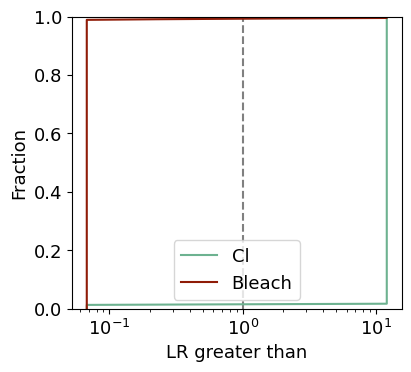

In [66]:
plt.figure(figsize=(4.4,4))

def cum_and_norm(x): return np.cumsum(x)/sum(x)

kde_Cl = gaussian_kde(lda_test6[0][np.array(data_test_norm6.index.get_level_values('Source')) == 'Cl'], bw_method=1)
kde_Bleach = gaussian_kde(lda_test6[0][np.array(data_test_norm6.index.get_level_values('Source')) == 'Bleach'], bw_method=1)
x_range = np.arange(-20, 20, .1)

plt.axvline(x=1, color='grey',  ls='--')
plt.plot(y_ELUB_test6, cum_and_norm([kde_Cl(x_) for x_ in x_range]), label='Cl', color='#6DB290') #[100:400]
plt.plot(y_ELUB_test6, cum_and_norm([kde_Bleach(x_) for x_ in x_range]), label='Bleach', color='#8F1B07') #[0:300]
plt.xlabel('LR greater than', fontsize = 13)
plt.ylabel('Fraction', fontsize = 13)
plt.xscale('log')

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)
plt.ylim(0, 1)

plt.legend(fontsize=13)
plt.gcf().subplots_adjust(left=0.15, bottom=0.15)

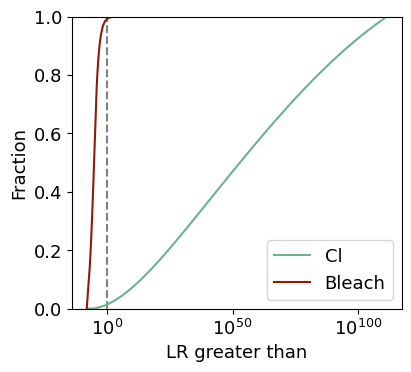

In [67]:
plt.figure(figsize=(4.4,4))

def cum_and_norm(x): return np.cumsum(x)/sum(x)

kde_Cl = gaussian_kde(lda_test6[0][np.array(data_test_norm6.index.get_level_values('Source')) == 'Cl'], bw_method=1)
kde_Bleach = gaussian_kde(lda_test6[0][np.array(data_test_norm6.index.get_level_values('Source')) == 'Bleach'], bw_method=1)
x_range = np.arange(-20, 20, .1)

plt.axvline(x=1, color='grey',  ls='--')
plt.plot([likelihood(x_) for x_ in x_range], cum_and_norm([kde_Cl(x_) for x_ in x_range]), label='Cl', color='#6DB290')
plt.plot([likelihood(x_) for x_ in x_range], cum_and_norm([kde_Bleach(x_) for x_ in x_range]), label='Bleach', color='#8F1B07')
plt.xlabel('LR greater than', fontsize = 13)
plt.ylabel('Fraction', fontsize = 13)
plt.xscale('log')
plt.xticks([1e0, 1e50, 1e100])

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)
plt.ylim(0, 1)

plt.legend(fontsize=13)
plt.gcf().subplots_adjust(left=0.15, bottom=0.15)

##### LR with ELUB

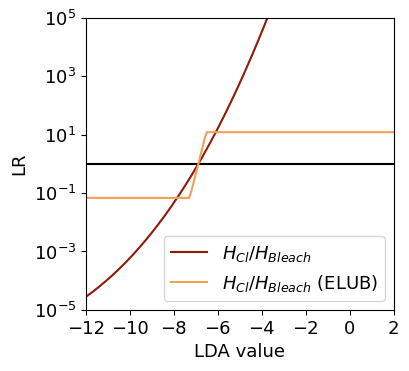

In [68]:
x = np.arange(-20, 20, 0.1)
y_test = [likelihood(x_) for x_ in np.arange(-20, 20, 0.1)]

fig, ax = plt.subplots(figsize=(4.4,4))
ax.axhline(1, color='black')
ax.plot(x, y_test, label=r'$H_{Cl} / H_{Bleach}$')
ax.plot(x, y_ELUB_test6, label=r'$H_{Cl} / H_{Bleach}$ (ELUB)', color='#F0A058')

ax.set_yscale('log')
ax.set_ylim(1e-5, 1e5)
ax.set_xlim(-12, 2)

plt.yticks(fontsize=13)
plt.xticks(fontsize=13)

ax.set_xlabel('LDA value', fontsize=13)
ax.set_ylabel('LR', fontsize=13)
plt.legend(fontsize = 13)

plt.gcf().subplots_adjust(left=0.20, bottom=0.15)

### Calculate LDA values 2D

#### LDA all data

In [69]:
def plot_hist(data, n, color, binwidth=0.5):
    plt.hist(
        data, 
        bins=np.arange(np.floor(data.min()), data.max()+binwidth, binwidth),
        weights=np.repeat(1/n, len(data)),
        color=color
    )

In [70]:
clf = LinearDiscriminantAnalysis()
clf.fit(X=data_pivot_MSMS, y=data_pivot_MSMS.index.get_level_values('Exposure'))

lda4 = pd.DataFrame(clf.transform(data_pivot_MSMS)[:,0:2], index=data_pivot_MSMS.index)
lda4

0          1
Source Source2     Exposure            Plant    N                      
Bleach Bleach high Concentrated bleach Euonymus 1 -12.986528  11.933316
                                                2 -12.940299  12.539201
                                                3 -12.246480  12.129799
                                       Grass    1 -12.379558  12.641159
                                                2 -12.286349  12.331645
...                                                      ...        ...
Cl     Cl          Chlorine, short     Nettle   2 -22.754303  20.162397
                                                3 -22.306293  20.584073
                                                4 -22.201002  20.575801
                                                5 -21.961024  20.830669
                                                6 -22.753202  20.490164

[69 rows x 2 columns]

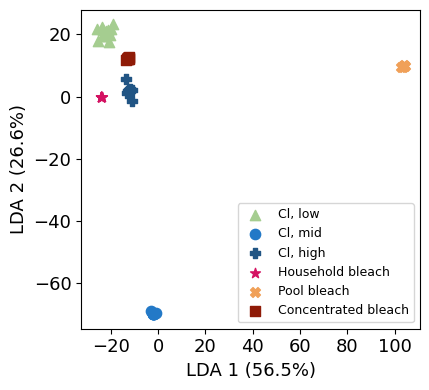

In [71]:
plt.figure(figsize=(4.4,4))

plt.scatter(lda4[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, short'], lda4[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, short'], color="#A5CD90", label='Cl, low', marker='^', s=55)
plt.scatter(lda4[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, long'],  lda4[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, long'], color="#2379C7", label='Cl, mid', marker='o', s=55)
plt.scatter(lda4[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, high'],  lda4[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Chlorine, high'],color="#215584", label='Cl, high', marker='P', s=55)
plt.scatter(lda4[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Household bleach'], lda4[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Household bleach'],  color="#D41262", label='Household bleach', marker='*', s=55)
plt.scatter(lda4[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Pool bleach'],      lda4[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Pool bleach'],color="#F0A058", label='Pool bleach', marker='X', s=50)
plt.scatter(lda4[0][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Concentrated bleach'], lda4[1][np.array(data_pivot_MSMS.index.get_level_values('Exposure')) == 'Concentrated bleach'],color="#8F1B07", label='Concentrated bleach', marker='s', s=50)

plt.xlabel(f'LDA 1 ({clf.explained_variance_ratio_[0]:.01%})', fontsize = 13)
plt.ylabel(f'LDA 2 ({clf.explained_variance_ratio_[1]:.01%})', fontsize = 13)

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

a = plt.legend(loc='lower right', ncol=1, fontsize = 9)

plt.tight_layout()

#### LDA training set

##### #4

In [72]:
clf = LinearDiscriminantAnalysis()
clf.fit(X=data_train_norm4, y=data_train_norm4.index.get_level_values('Exposure'))

lda_train = pd.DataFrame(clf.transform(data_train_norm4)[:,0:2], index=data_train_norm4.index)
lda_train

0          1
Source Source2     Exposure            Plant  N                      
Bleach Bleach high Concentrated bleach Grass  1 -36.391605 -14.533994
                                              2 -37.059441 -13.693848
                                              3 -38.662714 -13.685394
                                       Nettle 1 -36.706546 -12.815838
                                              2 -38.233211 -15.282650
...                                                    ...        ...
Cl     Cl          Chlorine, short     Nettle 2 -10.305050  24.274595
                                              3 -10.363542  21.072258
                                              4 -11.072236  20.772059
                                              5  -9.385010  20.644329
                                              6 -10.151669  23.994055

[48 rows x 2 columns]

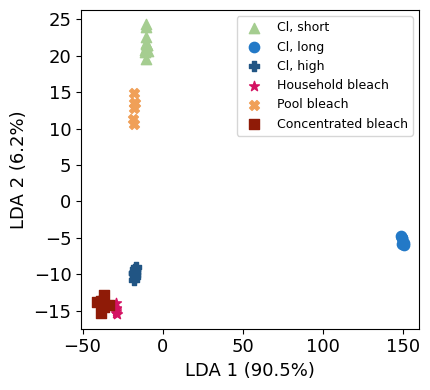

In [73]:
plt.figure(figsize=(4.4,4))

plt.scatter(lda_train[0][np.array(data_train_norm4.index.get_level_values('Exposure')) == 'Chlorine, short'], lda_train[1][np.array(data_train_norm4.index.get_level_values('Exposure')) == 'Chlorine, short'], color="#A5CD90", label='Cl, short', marker='^', s=55)
plt.scatter(lda_train[0][np.array(data_train_norm4.index.get_level_values('Exposure')) == 'Chlorine, long'],  lda_train[1][np.array(data_train_norm4.index.get_level_values('Exposure')) == 'Chlorine, long'], color="#2379C7", label='Cl, long', marker='o', s=55)
plt.scatter(lda_train[0][np.array(data_train_norm4.index.get_level_values('Exposure')) == 'Chlorine, high'],  lda_train[1][np.array(data_train_norm4.index.get_level_values('Exposure')) == 'Chlorine, high'],color="#215584", label='Cl, high', marker='P', s=55)
plt.scatter(lda_train[0][np.array(data_train_norm4.index.get_level_values('Exposure')) == 'Household bleach'], lda_train[1][np.array(data_train_norm4.index.get_level_values('Exposure')) == 'Household bleach'],  color="#D41262", label='Household bleach', marker='*', s=55)
plt.scatter(lda_train[0][np.array(data_train_norm4.index.get_level_values('Exposure')) == 'Pool bleach'],      lda_train[1][np.array(data_train_norm4.index.get_level_values('Exposure')) == 'Pool bleach'],color="#F0A058", label='Pool bleach', marker='X', s=50)
plt.scatter(lda_train[0][np.array(data_train_norm4.index.get_level_values('Exposure')) == 'Concentrated bleach'], lda_train[1][np.array(data_train_norm4.index.get_level_values('Exposure')) == 'Concentrated bleach'],color="#8F1B07", label='Concentrated bleach', marker='s', s=50)

plt.xlabel(f'LDA 1 ({clf.explained_variance_ratio_[0]:.01%})', fontsize = 13)
plt.ylabel(f'LDA 2 ({clf.explained_variance_ratio_[1]:.01%})', fontsize = 13)

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

a = plt.legend( ncol=1, fontsize = 9)

plt.tight_layout()

##### #5

In [74]:
clf = LinearDiscriminantAnalysis()
clf.fit(X=data_train_norm5, y=data_train_norm5.index.get_level_values('Exposure'))

lda_train = pd.DataFrame(clf.transform(data_train_norm5)[:,0:2], index=data_train_norm5.index)
lda_train

0          1
Source Source2     Exposure            Plant    N                      
Bleach Bleach high Concentrated bleach Euonymus 1  19.014341  14.137399
                                                2  19.269513  14.019668
                                                3  18.879178  16.038523
                                       Nettle   1  16.748308  13.488918
                                                2  20.714286  16.411539
...                                                      ...        ...
Cl     Cl          Chlorine, short     Nettle   2 -32.120381 -11.422526
                                                3 -32.086563  -9.869619
                                                4 -31.165373  -9.997807
                                                5 -31.318168 -10.972610
                                                6 -32.438405 -11.093522

[48 rows x 2 columns]

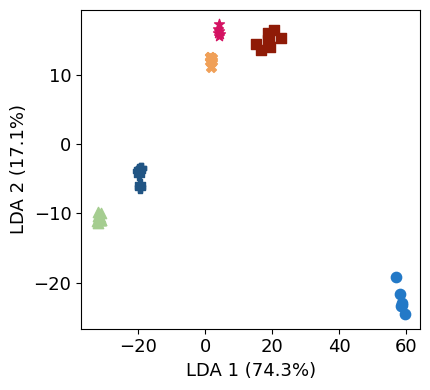

In [75]:
plt.figure(figsize=(4.4,4))

plt.scatter(lda_train[0][np.array(data_train_norm5.index.get_level_values('Exposure')) == 'Chlorine, short'],     lda_train[1][np.array(data_train_norm5.index.get_level_values('Exposure')) == 'Chlorine, short'], color="#A5CD90", label='Cl, low', marker='^', s=55)
plt.scatter(lda_train[0][np.array(data_train_norm5.index.get_level_values('Exposure')) == 'Chlorine, long'],      lda_train[1][np.array(data_train_norm5.index.get_level_values('Exposure')) == 'Chlorine, long'], color="#2379C7", label='Cl, mid', marker='o', s=55)
plt.scatter(lda_train[0][np.array(data_train_norm5.index.get_level_values('Exposure')) == 'Chlorine, high'],      lda_train[1][np.array(data_train_norm5.index.get_level_values('Exposure')) == 'Chlorine, high'],color="#215584", label='Cl, high', marker='P', s=55)
plt.scatter(lda_train[0][np.array(data_train_norm5.index.get_level_values('Exposure')) == 'Household bleach'],    lda_train[1][np.array(data_train_norm5.index.get_level_values('Exposure')) == 'Household bleach'],  color="#D41262", label='Household bleach', marker='*', s=55)
plt.scatter(lda_train[0][np.array(data_train_norm5.index.get_level_values('Exposure')) == 'Pool bleach'],         lda_train[1][np.array(data_train_norm5.index.get_level_values('Exposure')) == 'Pool bleach'],color="#F0A058", label='Pool bleach', marker='X', s=50)
plt.scatter(lda_train[0][np.array(data_train_norm5.index.get_level_values('Exposure')) == 'Concentrated bleach'], lda_train[1][np.array(data_train_norm5.index.get_level_values('Exposure')) == 'Concentrated bleach'],color="#8F1B07", label='Concentrated bleach', marker='s', s=50)

plt.xlabel(f'LDA 1 ({clf.explained_variance_ratio_[0]:.01%})', fontsize = 13)
plt.ylabel(f'LDA 2 ({clf.explained_variance_ratio_[1]:.01%})', fontsize = 13)

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

plt.tight_layout()

##### #6

In [76]:
clf = LinearDiscriminantAnalysis()
clf.fit(X=data_train_norm6, y=data_train_norm6.index.get_level_values('Exposure'))

lda_train6 = pd.DataFrame(clf.transform(data_train_norm6)[:,0:2], index=data_train_norm6.index)
lda_train6

0          1
Source Source2     Exposure            Plant    N                      
Bleach Bleach high Concentrated bleach Euonymus 1 -36.774951  11.464647
                                                2 -36.380683  11.664220
                                                3 -37.762125  12.963829
                                       Grass    1 -37.160298  11.431418
                                                2 -36.559751  12.179650
...                                                      ...        ...
Cl     Cl          Chlorine, short     Grass    2 -45.269319   2.129189
                                                3 -45.176942   1.621181
                                                4 -44.144946   2.420819
                                                5 -45.417319   1.009629
                                                6 -46.002160   2.938888

[42 rows x 2 columns]

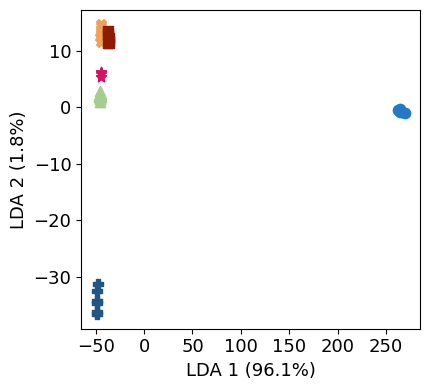

In [77]:
plt.figure(figsize=(4.4,4))

plt.scatter(lda_train6[0][np.array(data_train_norm6.index.get_level_values('Exposure')) == 'Chlorine, short'],     lda_train6[1][np.array(data_train_norm6.index.get_level_values('Exposure')) == 'Chlorine, short'], color="#A5CD90", label='Cl, low', marker='^', s=55)
plt.scatter(lda_train6[0][np.array(data_train_norm6.index.get_level_values('Exposure')) == 'Chlorine, long'],      lda_train6[1][np.array(data_train_norm6.index.get_level_values('Exposure')) == 'Chlorine, long'], color="#2379C7", label='Cl, mid', marker='o', s=55)
plt.scatter(lda_train6[0][np.array(data_train_norm6.index.get_level_values('Exposure')) == 'Chlorine, high'],      lda_train6[1][np.array(data_train_norm6.index.get_level_values('Exposure')) == 'Chlorine, high'],color="#215584", label='Cl, high', marker='P', s=55)
plt.scatter(lda_train6[0][np.array(data_train_norm6.index.get_level_values('Exposure')) == 'Household bleach'],    lda_train6[1][np.array(data_train_norm6.index.get_level_values('Exposure')) == 'Household bleach'],  color="#D41262", label='Household bleach', marker='*', s=55)
plt.scatter(lda_train6[0][np.array(data_train_norm6.index.get_level_values('Exposure')) == 'Pool bleach'],         lda_train6[1][np.array(data_train_norm6.index.get_level_values('Exposure')) == 'Pool bleach'],color="#F0A058", label='Pool bleach', marker='X', s=50)
plt.scatter(lda_train6[0][np.array(data_train_norm6.index.get_level_values('Exposure')) == 'Concentrated bleach'], lda_train6[1][np.array(data_train_norm6.index.get_level_values('Exposure')) == 'Concentrated bleach'],color="#8F1B07", label='Concentrated bleach', marker='s', s=50)

plt.xlabel(f'LDA 1 ({clf.explained_variance_ratio_[0]:.01%})', fontsize = 13)
plt.ylabel(f'LDA 2 ({clf.explained_variance_ratio_[1]:.01%})', fontsize = 13)

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

plt.tight_layout()

#### LDA test set

##### #4

In [78]:
clf = LinearDiscriminantAnalysis()
clf.fit(X=data_train_norm4, y=data_train_norm4.index.get_level_values('Exposure'))

lda_test4 = pd.DataFrame(clf.transform(data_test_norm4)[:,0:2], index=data_test_norm4.index)
lda_test4

0          1
Source Source2     Exposure            Plant    N                      
Bleach Bleach high Concentrated bleach Euonymus 1 -30.798454 -21.579495
                                                2 -24.132031 -18.837624
                                                3 -36.017495 -21.126661
       Bleach low  Household bleach    Euonymus 1 -13.777087 -19.474682
                                                2 -27.994023 -14.604404
...                                                      ...        ...
Cl     Cl          Chlorine, short     Euonymus 2 -29.035088  13.394342
                                                3 -26.318542   8.714211
                                                4  -8.354463  19.497156
                                                5  -8.090614  21.783433
                                                6 -18.048311  29.125194

[21 rows x 2 columns]

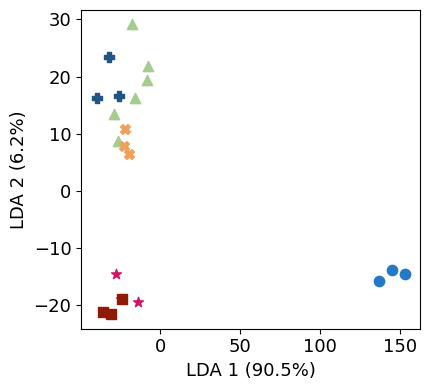

In [79]:
plt.figure(figsize=(4.4,4))

plt.scatter(lda_test4[0][np.array(data_test_norm4.index.get_level_values('Exposure')) == 'Chlorine, short'],     lda_test4[1][np.array(data_test_norm4.index.get_level_values('Exposure')) == 'Chlorine, short'], color="#A5CD90", label='Cl, low', marker='^', s=55)
plt.scatter(lda_test4[0][np.array(data_test_norm4.index.get_level_values('Exposure')) == 'Chlorine, long'],      lda_test4[1][np.array(data_test_norm4.index.get_level_values('Exposure')) == 'Chlorine, long'], color="#2379C7", label='Cl, mid', marker='o', s=55)
plt.scatter(lda_test4[0][np.array(data_test_norm4.index.get_level_values('Exposure')) == 'Chlorine, high'],      lda_test4[1][np.array(data_test_norm4.index.get_level_values('Exposure')) == 'Chlorine, high'],color="#215584", label='Cl, high', marker='P', s=55)
plt.scatter(lda_test4[0][np.array(data_test_norm4.index.get_level_values('Exposure')) == 'Household bleach'],    lda_test4[1][np.array(data_test_norm4.index.get_level_values('Exposure')) == 'Household bleach'],  color="#D41262", label='Household bleach', marker='*', s=55)
plt.scatter(lda_test4[0][np.array(data_test_norm4.index.get_level_values('Exposure')) == 'Pool bleach'],         lda_test4[1][np.array(data_test_norm4.index.get_level_values('Exposure')) == 'Pool bleach'],color="#F0A058", label='Pool bleach', marker='X', s=50)
plt.scatter(lda_test4[0][np.array(data_test_norm4.index.get_level_values('Exposure')) == 'Concentrated bleach'], lda_test4[1][np.array(data_test_norm4.index.get_level_values('Exposure')) == 'Concentrated bleach'],color="#8F1B07", label='Concentrated bleach', marker='s', s=50)

plt.xlabel(f'LDA 1 ({clf.explained_variance_ratio_[0]:.01%})', fontsize = 13)
plt.ylabel(f'LDA 2 ({clf.explained_variance_ratio_[1]:.01%})', fontsize = 13)

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

plt.tight_layout()

##### #5

In [80]:
clf = LinearDiscriminantAnalysis()
clf.fit(X=data_train_norm5, y=data_train_norm5.index.get_level_values('Exposure'))

lda_test5 = pd.DataFrame(clf.transform(data_test_norm5)[:,0:2], index=data_test_norm5.index)
lda_test5

0          1
Source Source2     Exposure            Plant N                      
Bleach Bleach high Concentrated bleach Grass 1  20.003850  14.389169
                                             2  16.841602  18.395160
                                             3  13.962758  15.302407
       Bleach low  Household bleach    Grass 1  -3.092962  14.689543
                                             2  -2.299671  15.486292
...                                                   ...        ...
Cl     Cl          Chlorine, short     Grass 2 -39.339223  -9.782311
                                             3 -30.458425  -8.712524
                                             4 -40.408990  -9.896649
                                             5 -36.212906 -12.389836
                                             6 -34.312385  -8.952748

[21 rows x 2 columns]

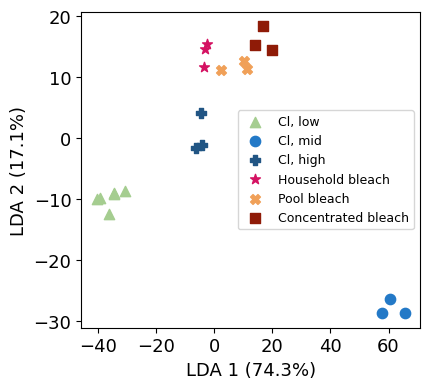

In [81]:
plt.figure(figsize=(4.4,4))

plt.scatter(lda_test5[0][np.array(data_test_norm5.index.get_level_values('Exposure')) == 'Chlorine, short'],     lda_test5[1][np.array(data_test_norm5.index.get_level_values('Exposure')) == 'Chlorine, short'], color="#A5CD90", label='Cl, low', marker='^', s=55)
plt.scatter(lda_test5[0][np.array(data_test_norm5.index.get_level_values('Exposure')) == 'Chlorine, long'],      lda_test5[1][np.array(data_test_norm5.index.get_level_values('Exposure')) == 'Chlorine, long'], color="#2379C7", label='Cl, mid', marker='o', s=55)
plt.scatter(lda_test5[0][np.array(data_test_norm5.index.get_level_values('Exposure')) == 'Chlorine, high'],      lda_test5[1][np.array(data_test_norm5.index.get_level_values('Exposure')) == 'Chlorine, high'],color="#215584", label='Cl, high', marker='P', s=55)
plt.scatter(lda_test5[0][np.array(data_test_norm5.index.get_level_values('Exposure')) == 'Household bleach'],    lda_test5[1][np.array(data_test_norm5.index.get_level_values('Exposure')) == 'Household bleach'],  color="#D41262", label='Household bleach', marker='*', s=55)
plt.scatter(lda_test5[0][np.array(data_test_norm5.index.get_level_values('Exposure')) == 'Pool bleach'],         lda_test5[1][np.array(data_test_norm5.index.get_level_values('Exposure')) == 'Pool bleach'],color="#F0A058", label='Pool bleach', marker='X', s=50)
plt.scatter(lda_test5[0][np.array(data_test_norm5.index.get_level_values('Exposure')) == 'Concentrated bleach'], lda_test5[1][np.array(data_test_norm5.index.get_level_values('Exposure')) == 'Concentrated bleach'],color="#8F1B07", label='Concentrated bleach', marker='s', s=50)

plt.xlabel(f'LDA 1 ({clf.explained_variance_ratio_[0]:.01%})', fontsize = 13)
plt.ylabel(f'LDA 2 ({clf.explained_variance_ratio_[1]:.01%})', fontsize = 13)

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

a = plt.legend(ncol=1, fontsize = 9)

plt.tight_layout()

##### #6

In [82]:
clf = LinearDiscriminantAnalysis()
clf.fit(X=data_train_norm6, y=data_train_norm6.index.get_level_values('Exposure'))

lda_test6 = pd.DataFrame(clf.transform(data_test_norm6)[:,0:2], index=data_test_norm6.index)
lda_test6

0          1
Source Source2     Exposure            Plant  N                      
Bleach Bleach high Concentrated bleach Nettle 1 -38.461160  13.338168
                                              2 -39.084047  12.410247
                                              3 -40.354210   6.352821
                                              4 -41.966655  12.505184
                                              5 -41.613066  12.911967
...                                                    ...        ...
Cl     Cl          Chlorine, short     Nettle 2 -49.606122  -2.106721
                                              3 -48.555374  -1.141746
                                              4 -45.837541   3.817041
                                              5 -45.567003   7.748013
                                              6 -47.558218   0.487072

[27 rows x 2 columns]

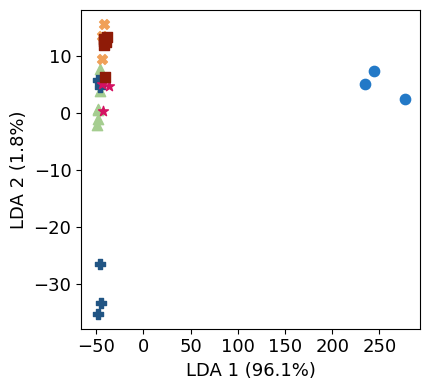

In [83]:
plt.figure(figsize=(4.4,4))

plt.scatter(lda_test6[0][np.array(data_test_norm6.index.get_level_values('Exposure')) == 'Chlorine, short'],     lda_test6[1][np.array(data_test_norm6.index.get_level_values('Exposure')) == 'Chlorine, short'], color="#A5CD90", label='Cl, low', marker='^', s=55)
plt.scatter(lda_test6[0][np.array(data_test_norm6.index.get_level_values('Exposure')) == 'Chlorine, long'],      lda_test6[1][np.array(data_test_norm6.index.get_level_values('Exposure')) == 'Chlorine, long'], color="#2379C7", label='Cl, mid', marker='o', s=55)
plt.scatter(lda_test6[0][np.array(data_test_norm6.index.get_level_values('Exposure')) == 'Chlorine, high'],      lda_test6[1][np.array(data_test_norm6.index.get_level_values('Exposure')) == 'Chlorine, high'],color="#215584", label='Cl, high', marker='P', s=55)
plt.scatter(lda_test6[0][np.array(data_test_norm6.index.get_level_values('Exposure')) == 'Household bleach'],    lda_test6[1][np.array(data_test_norm6.index.get_level_values('Exposure')) == 'Household bleach'],  color="#D41262", label='Household bleach', marker='*', s=55)
plt.scatter(lda_test6[0][np.array(data_test_norm6.index.get_level_values('Exposure')) == 'Pool bleach'],         lda_test6[1][np.array(data_test_norm6.index.get_level_values('Exposure')) == 'Pool bleach'],color="#F0A058", label='Pool bleach', marker='X', s=50)
plt.scatter(lda_test6[0][np.array(data_test_norm6.index.get_level_values('Exposure')) == 'Concentrated bleach'], lda_test6[1][np.array(data_test_norm6.index.get_level_values('Exposure')) == 'Concentrated bleach'],color="#8F1B07", label='Concentrated bleach', marker='s', s=50)

plt.xlabel(f'LDA 1 ({clf.explained_variance_ratio_[0]:.01%})', fontsize = 13)
plt.ylabel(f'LDA 2 ({clf.explained_variance_ratio_[1]:.01%})', fontsize = 13)

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

plt.tight_layout()